In [ ]:
!fusermount -u /content/gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm, fisher_exact
from scipy.optimize import curve_fit
from statsmodels.stats.multitest import fdrcorrection

sns.set(style="whitegrid")

print("Imports done!")

Imports done!


In [ ]:
# Load Input Files

base_dir = "/content/gdrive/MyDrive/Datasets"

mut_domainome_file = f"{base_dir}/mutated_domainome_merged_filtered.txt"
esm_file = f"{base_dir}/mut1vfl_annotated.csv"
ranked_domains_file = f"{base_dir}/domain_QC_summary_reproducibility_ranked.txt"

mut_df = pd.read_csv(mut_domainome_file, sep="\t")
esm_df = pd.read_csv(esm_file)
ranked_domains = pd.read_csv(ranked_domains_file, sep="\t")

print("mut_df shape:", mut_df.shape)
print("esm_df shape:", esm_df.shape)
print("ranked_domains shape:", ranked_domains.shape)


print("\nmut_df columns:", mut_df.columns.tolist())
print("esm_df columns:", esm_df.columns.tolist())
print("ranked_domains columns:", ranked_domains.columns.tolist())

#Keep only relevant columns from ESM
esm_df = esm_df[["aa_seq", "esm1vfl_score", 'entropy']]
#print("\nesm_df after column filtering:", esm_df.shape)

mut_df shape: (602882, 110)
esm_df shape: (595220, 14)
ranked_domains shape: (522, 36)

mut_df columns: ['wt_seq', 'aa_seq', 'dom_ID', 'variant_ID', 'pos', 'pos_in_uniprot', 'WT', 'wt_aa', 'mut_aa', 'nt_seq', 'Nham_nt', 'Nham_aa', 'Nmut_codons', 'indel', 'STOP', 'STOP_readthrough', 'count_e1_s0', 'count_e2_s0', 'count_e3_s0', 'count_e1_s1', 'count_e2_s1', 'count_e3_s1', 'mean_count', 'fitness1_uncorr', 'fitness2_uncorr', 'fitness3_uncorr', 'sigma1_uncorr', 'sigma2_uncorr', 'sigma3_uncorr', 'fitness', 'sigma', 'growthrate1', 'growthrate1_sigma', 'growthrate2', 'growthrate2_sigma', 'growthrate3', 'growthrate3_sigma', 'growthrate', 'growthrate_sigma', 'library', 'missing', 'dead', 'secondary_structure_code', 'secondary_structure', 'Phi', 'Psi', 'Area', 'sasa_all', 'rsasa_all', 'sasa_sidechain', 'rsasa_sidechain', 'sasa_mainchain', 'rsasa_mainchain', 'sasa_nonpolar', 'rsasa_nonpolar', 'sasa_polar', 'rsasa_polar', 'pLDDT', 'vdw_inter', 'vdw_intra', 'sb_inter', 'sb_intra', 'hbbb_inter', 'hbb

In [ ]:
esm_df.head()

,aa_seq,esm1vfl_score,entropy
0,KCKVCGKGFRQASTLCRHKIIH,-13.788274,0.014301
1,RCKVCGKGFRQASTLCRHKIIH,-13.782727,0.014301
2,HCKVCGKGFRQASTLCRHKIIH,-13.540111,0.014301
3,ECKVCGKGFRQASTLCRHKIIH,-8.389194,0.014301
4,DCKVCGKGFRQASTLCRHKIIH,-11.883451,0.014301


In [ ]:
#Merge ESM1v scores
mut_merged = pd.merge(mut_df, esm_df, on="aa_seq", how="left")

print("After merge, shape:", mut_merged.shape)
#Check how many rows have NA ESM1v + mutated
na_mask = mut_merged["esm1vfl_score"].isna() & (mut_merged["WT"] == False)
print("Rows with NA ESM1v & mutated:", na_mask.sum())

#Drop mutants without ESM1v
mut_merged = mut_merged[~na_mask]
print("After dropping those, shape:", mut_merged.shape)

print(mut_merged.head(5))

After merge, shape: (605281, 112)
Rows with NA ESM1v & mutated: 36901
After dropping those, shape: (568380, 112)
                   wt_seq                  aa_seq               dom_ID  \
2  ACEQCGKSFARKDMLKEHMRVH  AAEQCGKSFARKDMLKEHMRVH  P57071_PF00096_1085   
4  ACEQCGKSFARKDMLKEHMRVH  ACAQCGKSFARKDMLKEHMRVH  P57071_PF00096_1085   
5  ACEQCGKSFARKDMLKEHMRVH  ACCQCGKSFARKDMLKEHMRVH  P57071_PF00096_1085   
6  ACEQCGKSFARKDMLKEHMRVH  ACDQCGKSFARKDMLKEHMRVH  P57071_PF00096_1085   
8  ACEQCGKSFARKDMLKEHMRVH  ACEACGKSFARKDMLKEHMRVH  P57071_PF00096_1085   

                variant_ID  pos  pos_in_uniprot     WT wt_aa mut_aa  nt_seq  \
2  P57071_PF00096_1085_C2A  2.0          1086.0  False     C      A     NaN   
4  P57071_PF00096_1085_E3A  3.0          1087.0  False     E      A     NaN   
5  P57071_PF00096_1085_E3C  3.0          1087.0  False     E      C     NaN   
6  P57071_PF00096_1085_E3D  3.0          1087.0  False     E      D     NaN   
8  P57071_PF00096_1085_Q4A  4.0          1088.0

In [ ]:
mut_merged.shape

(568380, 112)

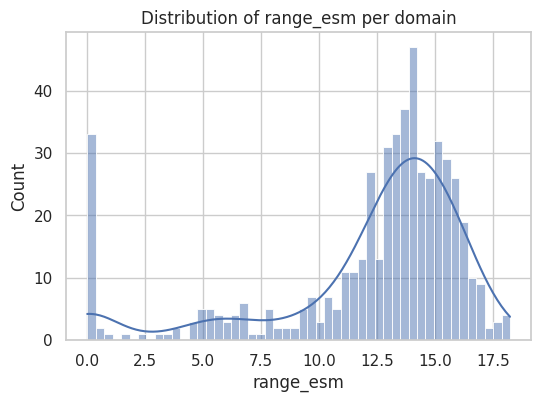

In [ ]:
#ESM Range Per Domain

mut_merged["PFAM_ID"] = mut_merged["dom_ID"].str.split("_", expand=True)[1]

def quantile_range(series):
    return np.diff(np.quantile(series.dropna(), [0.025, 0.975]))[0] if len(series.dropna()) > 0 else 0

esm1v_range_df = (mut_merged.groupby("dom_ID")["esm1vfl_score"].apply(lambda s: quantile_range(s)).reset_index(name="range_esm"))

# Quick distribution of range_esm
plt.figure(figsize=(6,4))
sns.histplot(data=esm1v_range_df, x="range_esm", bins=50, kde=True)
plt.title("Distribution of range_esm per domain")
plt.show()

Both plots have a big cluster around 12–15, and a visible drop-off below 10. There’s a spike at 0, which reflects: domains with only one variant, or domains where the ESM model gives the same score to all mutations

I am trying to pick the best protein domains for training or analyzing mutation effects, ones where the data is reliable and meaningful.

A big range means the model sees some mutations as good, and some as bad which is want we want.performs as a quility measure. The ESM model gives different scores for different mutations in this domain


In [ ]:
#Filter out narrow ESM range domains

good_domains = esm1v_range_df.loc[esm1v_range_df["range_esm"] > 10, "dom_ID"]
print("Number of domains with range_esm > 10:", len(good_domains))

wt_low = ranked_domains.loc[ranked_domains["wt_gr_percentile"] < 0.3, "dom_ID"]
print("Number of domains with wt_gr_percentile < 0.3:", len(wt_low))

doms_for_fitting = sorted(set(good_domains).intersection(set(wt_low)))
print("Number of final domains for fitting:", len(doms_for_fitting))

print("\nSample of doms_for_fitting:", doms_for_fitting[:10])

Number of domains with range_esm > 10: 425
Number of domains with wt_gr_percentile < 0.3: 478
Number of final domains for fitting: 392

Sample of doms_for_fitting: ['A1X283_PF00018_155', 'A1X283_PF00018_222', 'O00308_PF00397_440', 'O00330_PF02817_181', 'O14640_PF00778_4', 'O14776_PF01846_645', 'O14776_PF01846_727', 'O14776_PF01846_793', 'O14776_PF01846_897', 'O14776_PF01846_955']


In [ ]:

#Pre-fit Setup

mut_merged["scaled_gr_tofit"] = mut_merged["scaled_gr"] + 1


#define a sigmoid function
def sigmoid(x, xmid, scale):
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))

import math
from math import inf

# Debug function to see domain-level stats
def debug_domain_check(df_dom):
  print("    len:", len(df_dom))
  if len(df_dom) > 0:
    print("    esm1vfl_score range:", df_dom["esm1vfl_score"].min(),
          df_dom["esm1vfl_score"].max())
    print("    scaled_gr_tofit range:", df_dom["scaled_gr_tofit"].min(),
          df_dom["scaled_gr_tofit"].max())

In [ ]:
#Sigmoid Fitting

import math

data_out = []

for dom in doms_for_fitting:
  df_sub = mut_merged[(mut_merged["dom_ID"] == dom) & (mut_merged["mean_count"] > 9)
  & (~mut_merged["STOP"].fillna(False).astype(bool)) & (mut_merged["PFAM_ID"] != "rockdoms")].copy()

  print(f"\nFitting domain: {dom}")
  debug_domain_check(df_sub)

  if len(df_sub) < 10:
      print("    Skipped, too few rows.")
      continue


  df_sub = df_sub[
      (~df_sub["esm1vfl_score"].isna()) &
      (~df_sub["scaled_gr_tofit"].isna())]

  df_sub = df_sub.sort_values("esm1vfl_score")
  if len(df_sub) < 10:
      print("    Skipped, too few after removing NAs.")
      continue

  x = df_sub["esm1vfl_score"].values
  y = df_sub["scaled_gr_tofit"].values

  #Weighted approach: w = (max(y) - min(y) - y)**2
  y_min, y_max = y.min(), y.max()
  w = (y_max - y_min - y)**2

  best_deviance = math.inf
  best_params = None


  xmid_starts = np.arange(-5, -10.5, -0.5)
  scal_starts = np.geomspace(0.001, 1, 100)

  for xmid_start in xmid_starts:
      for scale_start in scal_starts:
          try:

                #clip w to avoid zero or negative
                w_clipped = np.clip(w, 1e-9, np.inf)
                sigma = 1 / np.sqrt(w_clipped)

                popt, pcov = curve_fit(f=sigmoid,xdata=x, ydata=y, p0=[xmid_start, scale_start], bounds=([-25, 0.0], [0.0, 1.0]),
                    sigma=sigma, absolute_sigma=False)
                y_pred = sigmoid(x, *popt)

                #Weighted deviance
                deviance = np.sum((y - y_pred)**2 * w)
                if deviance < best_deviance:
                  best_deviance = deviance
                  best_params = popt
          except RuntimeError:
                continue

  if best_params is None:
        print("Did not find any successful fit for this domain.")
        continue

    #If we got a best fit:
  print(f"    best_params: xmid={best_params[0]:.3f}, scale={best_params[1]:.4f}, deviance={best_deviance:.3f}")
  y_pred_final = sigmoid(x, *best_params)
  df_sub = df_sub.copy()
  df_sub["sigmoid_pred"] = y_pred_final
  df_sub["esm1v_residual"] = y - y_pred_final
  data_out.append(df_sub)

if len(data_out) == 0:
    raise ValueError("No objects to concatenate — no domain fits succeeded. Check logs above!")

df_res = pd.concat(data_out, axis=0)
print("\nAll done fitting. df_res shape:", df_res.shape)

<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: A1X283_PF00018_155
    len: 957
    esm1vfl_score range: -21.38083839416504 2.2166008949279785
    scaled_gr_tofit range: -0.21726561480038997 1.192703910118299
    best_params: xmid=-12.798, scale=1.0000, deviance=77.171

Fitting domain: A1X283_PF00018_222
    len: 1045
    esm1vfl_score range: -21.597877502441406 2.377678394317627
    scaled_gr_tofit range: -0.63469418822461 1.199671029036637


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.846, scale=1.0000, deviance=211.526


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O00308_PF00397_440
    len: 999
    esm1vfl_score range: -20.3867244720459 1.9587860107421875
    scaled_gr_tofit range: -0.35848400108874 1.345699371432338
    best_params: xmid=-12.985, scale=1.0000, deviance=98.718


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O00330_PF02817_181
    len: 881
    esm1vfl_score range: -20.22767639160156 3.623762607574463
    scaled_gr_tofit range: -0.2877983073769299 1.538896350227804
    best_params: xmid=-10.537, scale=1.0000, deviance=230.434

Fitting domain: O14640_PF00778_4
    len: 1413
    esm1vfl_score range: -21.549278259277344 6.884057998657227
    scaled_gr_tofit range: -0.23451200209215006 1.566235638153385


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.520, scale=1.0000, deviance=384.962

Fitting domain: O14776_PF01846_645
    len: 1288
    esm1vfl_score range: -22.60670757293701 -1.404897689819336
    scaled_gr_tofit range: -0.3094510387367799 1.155592260784473


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.533, scale=1.0000, deviance=99.364

Fitting domain: O14776_PF01846_727
    len: 907
    esm1vfl_score range: -22.04563450813293 -0.8064862833296934
    scaled_gr_tofit range: -0.50893316851481 1.225795575258028


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.830, scale=1.0000, deviance=168.989

Fitting domain: O14776_PF01846_793
    len: 1162
    esm1vfl_score range: -22.34562983151656 1.600510934266964
    scaled_gr_tofit range: -0.31408226703810005 1.131339383795475


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.326, scale=1.0000, deviance=99.825

Fitting domain: O14776_PF01846_897
    len: 1055
    esm1vfl_score range: -17.09153864401675 1.38123791091156
    scaled_gr_tofit range: -0.7018054634369 1.4355713797174001


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.555, scale=1.0000, deviance=369.474

Fitting domain: O14776_PF01846_955
    len: 779
    esm1vfl_score range: -18.253791392946 1.7622535204165324
    scaled_gr_tofit range: -0.29659608596769993 1.394812556801493


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.310, scale=1.0000, deviance=185.454

Fitting domain: O14813_PF00046_92
    len: 1008
    esm1vfl_score range: -24.32471466064453 -2.372140884399414
    scaled_gr_tofit range: -0.17979468574718993 1.412500045798333


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.353, scale=1.0000, deviance=188.120

Fitting domain: O14901_PF00096_395
    len: 448
    esm1vfl_score range: -24.142730712890625 -2.452545166015625
    scaled_gr_tofit range: -0.31224183143628004 1.7073432340872912


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.632, scale=1.0000, deviance=216.209

Fitting domain: O14936_PF00595_488
    len: 1520
    esm1vfl_score range: -22.35559463500977 1.7646082639694214
    scaled_gr_tofit range: -0.31906128924305 1.175408247570677


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.910, scale=1.0000, deviance=105.439

Fitting domain: O15151_PF00641_299
    len: 567
    esm1vfl_score range: -20.65844345092773 0.5980319976806641
    scaled_gr_tofit range: -0.4511097229574801 1.44756548996784


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.288, scale=1.0000, deviance=108.297

Fitting domain: O15265_PF08313_334
    len: 1123
    esm1vfl_score range: -21.59033393859864 0.9525928497314452
    scaled_gr_tofit range: -0.17710932333684992 1.189707110711192


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.231, scale=1.0000, deviance=72.841

Fitting domain: O15266_PF00046_119
    len: 1008
    esm1vfl_score range: -24.91684341430664 -4.274346828460693
    scaled_gr_tofit range: -0.3811189041985601 1.560764124610627


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.651, scale=1.0000, deviance=294.100

Fitting domain: O15405_PF00505_256
    len: 1229
    esm1vfl_score range: -23.5651798248291 -0.5519503951072693
    scaled_gr_tofit range: -0.29693588242653 1.509479241957096


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.471, scale=1.0000, deviance=254.853

Fitting domain: O15541_PF00642_198
    len: 471
    esm1vfl_score range: -20.509973526000977 -3.2681684494018555
    scaled_gr_tofit range: -0.31639645683017004 1.852824596212838


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.397, scale=1.0000, deviance=207.891

Fitting domain: O43167_PF00096_351
    len: 413
    esm1vfl_score range: -23.09167861938477 0.2678146362304687
    scaled_gr_tofit range: -0.3563729928594299 1.429601561700773


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.619, scale=1.0000, deviance=79.748

Fitting domain: O43167_PF00096_435
    len: 361
    esm1vfl_score range: -21.81208038330078 -1.6863837242126465
    scaled_gr_tofit range: -0.2760057518049901 1.558347844737441


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.415, scale=1.0000, deviance=93.303

Fitting domain: O43186_PF00046_41
    len: 964
    esm1vfl_score range: -22.97175025939941 4.433929443359375
    scaled_gr_tofit range: -0.11285095645896992 1.583063843051585


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.580, scale=1.0000, deviance=173.283

Fitting domain: O43295_PF00018_745
    len: 979
    esm1vfl_score range: -21.818568229675293 3.839820384979248
    scaled_gr_tofit range: -0.15760242207423003 1.177765673052285


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.768, scale=1.0000, deviance=42.409

Fitting domain: O43353_PF00619_438
    len: 1282
    esm1vfl_score range: -20.38622665405273 0.1627852916717529
    scaled_gr_tofit range: -0.40578387236032 1.5423685098787


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.487, scale=1.0000, deviance=392.715

Fitting domain: O43395_PF01480_10
    len: 1203
    esm1vfl_score range: -18.340496063232425 1.7232887744903564
    scaled_gr_tofit range: -0.26123616183959997 1.456352807770127


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.435, scale=1.0000, deviance=204.595

Fitting domain: O43586_PF00018_361
    len: 1009
    esm1vfl_score range: -22.085453033447266 1.8946218490600584
    scaled_gr_tofit range: -0.1685729439880801 1.11890436664548


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.600, scale=1.0000, deviance=49.773

Fitting domain: O60341_PF04433_186
    len: 1477
    esm1vfl_score range: -17.659645080566406 0.6091156005859375
    scaled_gr_tofit range: -0.2166376740590299 1.146741470856647


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.593, scale=1.0000, deviance=115.215

Fitting domain: O60481_PF00096_389
    len: 419
    esm1vfl_score range: -24.980615615844727 0.662816047668457
    scaled_gr_tofit range: -0.4256074294127099 1.66294707949506


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-18.330, scale=1.0000, deviance=200.706


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O75112_PF00595_1
    len: 1559
    esm1vfl_score range: -24.24002456665039 0.9352865219116212
    scaled_gr_tofit range: -0.34659044349637 1.172782663709955
    best_params: xmid=-16.175, scale=1.0000, deviance=172.428

Fitting domain: O75360_PF00046_71
    len: 1008
    esm1vfl_score range: -21.290037155151367 2.559783458709717
    scaled_gr_tofit range: -0.30425728003509 1.460143093629429


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.109, scale=1.0000, deviance=188.219

Fitting domain: O75366_PF02209_785
    len: 600
    esm1vfl_score range: -16.682472229003906 0.3509807586669922
    scaled_gr_tofit range: -0.39710357637984006 1.355450397064952


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.386, scale=1.0000, deviance=130.228

Fitting domain: O75382_PF00643_111
    len: 725
    esm1vfl_score range: -19.52082633972168 -0.5022854208946228
    scaled_gr_tofit range: -0.6819325958132301 1.718856407937644


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.108, scale=1.0000, deviance=239.995

Fitting domain: O75400_PF00397_176
    len: 963
    esm1vfl_score range: -22.08026885986328 0.6437416076660156
    scaled_gr_tofit range: -0.34594485734719993 1.769802857754146


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.457, scale=1.0000, deviance=343.463


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O75400_PF01846_395
    len: 909
    esm1vfl_score range: -24.21212387084961 -1.9779900312423704
    scaled_gr_tofit range: -0.26063874971524004 1.405967097323462
    best_params: xmid=-13.872, scale=1.0000, deviance=163.753

Fitting domain: O75400_PF01846_459
    len: 919
    esm1vfl_score range: -22.78513526916504 0.1197695732116699
    scaled_gr_tofit range: -0.2832479714734 1.481172823658459


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.825, scale=1.0000, deviance=232.222


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O75400_PF01846_670
    len: 914
    esm1vfl_score range: -21.2714900970459 0.2927312850952148
    scaled_gr_tofit range: -0.15666571926032002 1.678621280111267
    best_params: xmid=-12.169, scale=1.0000, deviance=246.494

Fitting domain: O75400_PF01846_745
    len: 1064
    esm1vfl_score range: -22.341941833496094 0.7558413147926331
    scaled_gr_tofit range: -0.2538480644033101 1.220989077391664


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.041, scale=1.0000, deviance=110.194

Fitting domain: O75478_PF04433_375
    len: 1162
    esm1vfl_score range: -17.05545425415039 -0.3589909076690674
    scaled_gr_tofit range: -0.1236764414715299 1.4192331930109199


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.460, scale=1.0000, deviance=105.637

Fitting domain: O75534_PF00313_184
    len: 1232
    esm1vfl_score range: -22.67519760131836 -0.4096260070800781
    scaled_gr_tofit range: -0.28489795602243007 1.288669248089616


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.924, scale=1.0000, deviance=175.296

Fitting domain: O75534_PF00313_23
    len: 1196
    esm1vfl_score range: -20.873449325561523 -0.6022128462791443
    scaled_gr_tofit range: -0.16220952791084997 1.113723106897209


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.493, scale=1.0000, deviance=34.683


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O75534_PF00313_347
    len: 1071
    esm1vfl_score range: -21.41201400756836 2.6832728385925293
    scaled_gr_tofit range: -0.31848442570712 1.336766220141367
    best_params: xmid=-11.406, scale=1.0000, deviance=174.602

Fitting domain: O75554_PF06220_8
    len: 594
    esm1vfl_score range: -22.40213966369629 -0.8159723281860352
    scaled_gr_tofit range: -0.5904704605983 1.4041103560865649


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.195, scale=1.0000, deviance=166.945


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O75970_PF00595_372
    len: 1674
    esm1vfl_score range: -20.67341947555542 0.9171097278594972
    scaled_gr_tofit range: -0.21215499793987003 1.367970818255021
    best_params: xmid=-7.500, scale=1.0000, deviance=158.378

Fitting domain: O94830_PF00536_389
    len: 1065
    esm1vfl_score range: -19.465909957885746 1.5341068506240845
    scaled_gr_tofit range: -0.9217310147248301 1.977287329666618


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.138, scale=1.0000, deviance=1000.937

Fitting domain: O94885_PF00536_630
    len: 1314
    esm1vfl_score range: -21.18769212612833 1.5250675677166343
    scaled_gr_tofit range: -0.3529572197108799 1.5146711177476


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.175, scale=1.0000, deviance=277.019


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O94929_PF00412_149
    len: 1061
    esm1vfl_score range: -19.020170211791992 1.7076754570007324
    scaled_gr_tofit range: -0.3006999543681099 1.336907584000687
    best_params: xmid=-11.904, scale=1.0000, deviance=128.037


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O94929_PF00412_210
    len: 1063
    esm1vfl_score range: -19.15699005126953 -1.035616397857666
    scaled_gr_tofit range: -0.26604012260918997 1.8618124008116679
    best_params: xmid=-13.130, scale=1.0000, deviance=313.460


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O94993_PF00505_338
    len: 1134
    esm1vfl_score range: -24.602882385253903 -2.079159736633301
    scaled_gr_tofit range: -0.46165255493567003 1.333875296707303
    best_params: xmid=-14.339, scale=1.0000, deviance=255.733

Fitting domain: O95076_PF00046_155
    len: 974
    esm1vfl_score range: -24.17597389221192 -0.7241024971008301
    scaled_gr_tofit range: -0.21906442939100002 1.365513590599674


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.728, scale=1.0000, deviance=147.970

Fitting domain: O95155_PF04564_1229
    len: 1184
    esm1vfl_score range: -19.084477414163 1.817339958205155
    scaled_gr_tofit range: -0.17488311160206993 1.391946063969796


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.906, scale=1.0000, deviance=136.173

Fitting domain: O95218_PF00641_11
    len: 474
    esm1vfl_score range: -22.05615425109864 -5.516465663909912
    scaled_gr_tofit range: -0.2750192049718201 2.2550674450986197


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.308, scale=1.0000, deviance=228.728

Fitting domain: O95218_PF00641_9
    len: 447
    esm1vfl_score range: -22.05615425109864 -5.516465663909912
    scaled_gr_tofit range: -0.32925406965604 1.633989905004055


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.777, scale=1.0000, deviance=170.615

Fitting domain: O95267_PF00130_539
    len: 928
    esm1vfl_score range: -20.302446365356445 4.963831901550293
    scaled_gr_tofit range: -0.29118160282709993 1.318686903867206


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.155, scale=1.0000, deviance=95.499


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: O95343_PF00046_212
    len: 935
    esm1vfl_score range: -24.49504280090332 2.044485569000244
    scaled_gr_tofit range: -0.22953281945625004 1.396791728638701
    best_params: xmid=-13.322, scale=1.0000, deviance=168.681

Fitting domain: O95475_PF00046_134
    len: 950
    esm1vfl_score range: -23.70903968811035 2.044485569000244
    scaled_gr_tofit range: -0.12968456467918998 1.568468899110367


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.123, scale=1.0000, deviance=200.611

Fitting domain: O95718_PF00105_100
    len: 1452
    esm1vfl_score range: -23.176170349121094 -0.6359567642211914
    scaled_gr_tofit range: -0.48505999089607 1.445190631138607


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.175, scale=1.0000, deviance=462.516

Fitting domain: O95793_PF00035_183
    len: 1195
    esm1vfl_score range: -23.94889640808105 2.920426368713379
    scaled_gr_tofit range: -0.40542666751772005 1.216115637200911


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.653, scale=1.0000, deviance=187.982

Fitting domain: O95817_PF00397_11
    len: 889
    esm1vfl_score range: -20.677255630493164 -1.415517807006836
    scaled_gr_tofit range: -0.33086277735690994 2.5616449441006397


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.449, scale=1.0000, deviance=740.961

Fitting domain: O95835_PF00627_98
    len: 772
    esm1vfl_score range: -17.770806381125855 3.050006296231064
    scaled_gr_tofit range: -0.34141848264113994 1.249267357938927


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.895, scale=1.0000, deviance=65.815

Fitting domain: P00519_PF00018_64
    len: 892
    esm1vfl_score range: -21.70743363415606 0.4420948028564453
    scaled_gr_tofit range: -0.17856433296180008 1.4399451423954779


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.422, scale=1.0000, deviance=89.730

Fitting domain: P02417_PF01281_1
    len: 714
    esm1vfl_score range: -15.219101905822754 3.734951972961426
    scaled_gr_tofit range: -0.25290866604578 1.23103022393858


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.845, scale=1.0000, deviance=78.701

Fitting domain: P02585_PF13499_1
    len: 1137
    esm1vfl_score range: -17.338685989379883 1.9911036491394043
    scaled_gr_tofit range: -0.53705786589531 1.241535204886513


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.172, scale=1.0000, deviance=112.047

Fitting domain: P02633_PF01023_1
    len: 1486
    esm1vfl_score range: -17.867637634277344 0.4973886013031006
    scaled_gr_tofit range: -2.0757674287902 1.279382581604055


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.720, scale=1.0000, deviance=1261.961

Fitting domain: P02640_PF02209_762
    len: 1235
    esm1vfl_score range: -18.281055450439453 0.0697474479675293
    scaled_gr_tofit range: -0.34860202658039996 1.3318815067155119


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.580, scale=1.0000, deviance=133.304

Fitting domain: P02640_PF02209_792
    len: 624
    esm1vfl_score range: -18.281055450439453 0.0697474479675293
    scaled_gr_tofit range: -0.2574502357811801 1.6038943545129452


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.731, scale=1.0000, deviance=116.163


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P03034_PF01381_4
    len: 1408
    esm1vfl_score range: -16.824066162109375 2.4302399158477783
    scaled_gr_tofit range: -0.37097748227333005 1.40960253023235
    best_params: xmid=-7.009, scale=1.0000, deviance=240.168

Fitting domain: P04049_PF02196_58
    len: 1230
    esm1vfl_score range: -19.031879425048828 1.9433709383010864
    scaled_gr_tofit range: -0.1927085609366701 1.3740014146833701


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.160, scale=1.0000, deviance=180.240


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P04150_PF00105_419
    len: 1392
    esm1vfl_score range: -23.563751220703125 -1.358290672302246
    scaled_gr_tofit range: -0.39746242523204 1.189885266955825
    best_params: xmid=-15.968, scale=1.0000, deviance=138.499


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))



Fitting domain: P05813_PF00030_31
    len: 1649
    esm1vfl_score range: -18.523765563964844 0.2258715629577636
    scaled_gr_tofit range: -0.27522316947010994 1.371339711358829


<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.195, scale=1.0000, deviance=224.645


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P06239_PF00018_63
    len: 1036
    esm1vfl_score range: -19.88214111328125 3.240572452545166
    scaled_gr_tofit range: -0.28210233782614 1.285025424800768
    best_params: xmid=-8.345, scale=1.0000, deviance=88.674

Fitting domain: P06241_PF00018_83
    len: 1136
    esm1vfl_score range: -23.51114273071289 0.3098039627075195
    scaled_gr_tofit range: -0.2864071311379299 1.223060645845412


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.052, scale=1.0000, deviance=57.224

Fitting domain: P07315_PF00030_4
    len: 1130
    esm1vfl_score range: -15.130292892456056 1.3703439235687256
    scaled_gr_tofit range: -0.22645422062629006 1.316780946061388


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.053, scale=1.0000, deviance=98.252

Fitting domain: P07315_PF00030_91
    len: 1211
    esm1vfl_score range: -15.927472114562988 2.0819196701049805
    scaled_gr_tofit range: -0.18738466800824005 1.212392167299166


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.247, scale=1.0000, deviance=104.966

Fitting domain: P07316_PF00030_1
    len: 657
    esm1vfl_score range: -13.961071014404297 0.8427452445030212
    scaled_gr_tofit range: -0.31808816427794007 1.282963379693939


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.548, scale=1.0000, deviance=90.177

Fitting domain: P08151_PF00096_363
    len: 494
    esm1vfl_score range: -24.45710729283924 -0.4249332615865313
    scaled_gr_tofit range: -0.23941842245717004 1.7205657635008849


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-18.152, scale=1.0000, deviance=200.768

Fitting domain: P08235_PF00105_600
    len: 1268
    esm1vfl_score range: -23.22450256347656 3.2187891006469727
    scaled_gr_tofit range: -0.36932421358230005 1.137615044803476


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.404, scale=1.0000, deviance=133.660

Fitting domain: P08631_PF00018_80
    len: 777
    esm1vfl_score range: -21.09256362915039 0.4098536968231201
    scaled_gr_tofit range: -0.14989700938080008 1.238151285627188


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.216, scale=1.0000, deviance=37.356

Fitting domain: P09086_PF00157_200
    len: 1254
    esm1vfl_score range: -24.54658317565918 0.460087776184082
    scaled_gr_tofit range: -0.22611215934126006 1.172911868640018


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.260, scale=1.0000, deviance=89.155


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P09327_PF02209_793
    len: 623
    esm1vfl_score range: -18.94224739074707 0.9314939975738524
    scaled_gr_tofit range: -0.29272425621456 1.66561969358929
    best_params: xmid=-9.788, scale=1.0000, deviance=192.082


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P0A9X9_PF00313_3
    len: 1270
    esm1vfl_score range: -19.747303009033203 0.852050244808197
    scaled_gr_tofit range: -0.34479872214111995 1.167149964609074
    best_params: xmid=-11.306, scale=1.0000, deviance=102.252


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P0CI26_PF00643_87
    len: 877
    esm1vfl_score range: -15.96242904663086 3.635966300964356
    scaled_gr_tofit range: -0.26633540499694 1.693699405684435
    best_params: xmid=-6.964, scale=1.0000, deviance=221.669


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P10242_PF00249_143
    len: 958
    esm1vfl_score range: -23.577556610107425 -3.0500707626342773
    scaled_gr_tofit range: -0.44670250069035 1.258133980206895
    best_params: xmid=-17.510, scale=1.0000, deviance=144.528


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P10242_PF00249_40
    len: 810
    esm1vfl_score range: -23.83161354064941 -3.243721008300781
    scaled_gr_tofit range: -0.3784817191551899 1.389973984516735
    best_params: xmid=-16.156, scale=1.0000, deviance=133.786

Fitting domain: P10275_PF00105_557
    len: 974
    esm1vfl_score range: -23.807937622070312 -3.918411254882813
    scaled_gr_tofit range: -0.4461684654233 1.215550558903379


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.805, scale=1.0000, deviance=164.049

Fitting domain: P10398_PF02196_21
    len: 1119
    esm1vfl_score range: -20.62549591064453 1.695091724395752
    scaled_gr_tofit range: -0.15558745491085002 1.258496855570233


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.322, scale=1.0000, deviance=104.083

Fitting domain: P10589_PF00105_83
    len: 1401
    esm1vfl_score range: -23.64654922485352 -2.886413097381592
    scaled_gr_tofit range: -0.5110961931564699 1.600006305125987


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.832, scale=1.0000, deviance=599.987

Fitting domain: P10826_PF00105_85
    len: 1457
    esm1vfl_score range: -24.0821533203125 0.6978607177734375
    scaled_gr_tofit range: -0.52834844281371 1.35271842347477


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.470, scale=1.0000, deviance=420.819

Fitting domain: P11182_PF02817_171
    len: 689
    esm1vfl_score range: -20.79914283752441 1.0986170768737793
    scaled_gr_tofit range: -0.3764987209069901 1.145452121685027


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.189, scale=1.0000, deviance=68.091

Fitting domain: P11308_PF02198_117
    len: 1512
    esm1vfl_score range: -23.408706665039062 0.3040585517883301
    scaled_gr_tofit range: -0.40189832184544994 1.327704900682606


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.203, scale=1.0000, deviance=169.754

Fitting domain: P11844_PF00030_85
    len: 1684
    esm1vfl_score range: -15.832161903381348 1.0933237075805664
    scaled_gr_tofit range: -0.3473990053118501 1.714390636976616


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.031, scale=1.0000, deviance=558.342

Fitting domain: P11961_PF02817_126
    len: 876
    esm1vfl_score range: -23.677000045776367 1.0824813842773438
    scaled_gr_tofit range: -0.3247119314981799 1.421034764613391


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.439, scale=1.0000, deviance=122.220

Fitting domain: P12931_PF00018_87
    len: 893
    esm1vfl_score range: -22.81146812438965 0.0888094902038574
    scaled_gr_tofit range: -0.16030678623429995 1.39599823678429


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.354, scale=1.0000, deviance=76.394

Fitting domain: P12956_PF02037_558
    len: 881
    esm1vfl_score range: -23.00630187988281 0.4629814624786377
    scaled_gr_tofit range: -0.25881051226743 1.2997767717526871


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.696, scale=1.0000, deviance=96.969

Fitting domain: P13796_PF13499_13
    len: 1511
    esm1vfl_score range: -22.01943588256836 1.6972668170928955
    scaled_gr_tofit range: -0.3830619181871999 1.203095271053654


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.327, scale=1.0000, deviance=137.329

Fitting domain: P13984_PF02270_177
    len: 1153
    esm1vfl_score range: -21.06944465637207 11.023386001586914
    scaled_gr_tofit range: -0.24212468619968996 1.131343669787254


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.769, scale=1.0000, deviance=70.534

Fitting domain: P14598_PF00018_157
    len: 1230
    esm1vfl_score range: -21.85771751403809 1.932760238647461
    scaled_gr_tofit range: -0.28998742689305 1.178612009361985


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.210, scale=1.0000, deviance=107.777

Fitting domain: P14653_PF00046_208
    len: 970
    esm1vfl_score range: -24.15421485900879 -0.0510635375976562
    scaled_gr_tofit range: -0.3053710987171401 1.445239926708018


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.168, scale=1.0000, deviance=208.617

Fitting domain: P14859_PF00157_285
    len: 1205
    esm1vfl_score range: -25.347213745117188 0.460087776184082
    scaled_gr_tofit range: -0.18771545246389 1.142352896057991


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.483, scale=1.0000, deviance=61.807

Fitting domain: P14921_PF02198_55
    len: 1471
    esm1vfl_score range: -22.670196533203125 1.332763910293579
    scaled_gr_tofit range: -0.15118492010068008 1.170199263387849


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.869, scale=1.0000, deviance=64.241

Fitting domain: P15056_PF02196_153
    len: 1434
    esm1vfl_score range: -22.79285430908203 -5.286898612976074
    scaled_gr_tofit range: -0.27204600140730006 1.135439851917011


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.086, scale=1.0000, deviance=101.410


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P15498_PF00018_592
    len: 1205
    esm1vfl_score range: -20.676603317260746 2.4231228828430176
    scaled_gr_tofit range: -0.17449427281610008 1.192730620195337
    best_params: xmid=-9.703, scale=1.0000, deviance=81.750


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P15498_PF00018_782
    len: 1116
    esm1vfl_score range: -22.70088577270508 0.6028070449829102
    scaled_gr_tofit range: -0.21139310572923997 1.231675764892106
    best_params: xmid=-10.213, scale=1.0000, deviance=97.981


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P16885_PF00018_772
    len: 824
    esm1vfl_score range: -18.125689620176907 1.3137227039300088
    scaled_gr_tofit range: -0.1388876045656 1.2458861160103991
    best_params: xmid=-5.314, scale=1.0000, deviance=75.220


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P16989_PF00313_84
    len: 1606
    esm1vfl_score range: -22.512693405151367 -2.0901198387146
    scaled_gr_tofit range: -0.35349526640580997 1.366007947058749
    best_params: xmid=-14.083, scale=1.0000, deviance=331.350

Fitting domain: P17480_PF00505_408
    len: 1159
    esm1vfl_score range: -22.4153060913086 1.649380803108215
    scaled_gr_tofit range: -0.50488299289235 1.103980881674486


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.449, scale=1.0000, deviance=146.168

Fitting domain: P19793_PF00105_132
    len: 1188
    esm1vfl_score range: -24.583045959472656 -1.1476025581359863
    scaled_gr_tofit range: -0.3052039912759501 1.209839741582986


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.200, scale=1.0000, deviance=141.504

Fitting domain: P19878_PF00018_241
    len: 1089
    esm1vfl_score range: -22.70021629333496 -0.1847701668739318
    scaled_gr_tofit range: -0.23217822438075997 1.298513205735358


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.118, scale=1.0000, deviance=127.348

Fitting domain: P19878_PF00018_456
    len: 1116
    esm1vfl_score range: -23.76939010620117 3.021740674972534
    scaled_gr_tofit range: -0.2727504027562 2.16572555962497


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.457, scale=1.0000, deviance=857.150

Fitting domain: P19878_PF00564_353
    len: 1232
    esm1vfl_score range: -17.01507568359375 1.6942378282546997
    scaled_gr_tofit range: -0.2485100725423599 1.516093364588842


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.312, scale=1.0000, deviance=213.229

Fitting domain: P20264_PF00046_408
    len: 952
    esm1vfl_score range: -25.22671890258789 -0.1165142059326171
    scaled_gr_tofit range: -0.30136998165491 1.247534685055972


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.118, scale=1.0000, deviance=133.027

Fitting domain: P20264_PF00157_320
    len: 1020
    esm1vfl_score range: -24.324756622314453 -4.877367973327637
    scaled_gr_tofit range: -0.22261912929375005 1.401655447551113


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.871, scale=1.0000, deviance=171.517

Fitting domain: P20265_PF00046_356
    len: 1030
    esm1vfl_score range: -25.33589553833008 -0.2262716293334961
    scaled_gr_tofit range: -0.24779202802319 1.265310030626192


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.190, scale=1.0000, deviance=141.856

Fitting domain: P20265_PF00157_262
    len: 1382
    esm1vfl_score range: -24.12555313110352 -3.199967384338379
    scaled_gr_tofit range: -0.48283053717018 1.265256453879503


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.860, scale=1.0000, deviance=243.031

Fitting domain: P20936_PF00018_281
    len: 1157
    esm1vfl_score range: -20.732359170913696 0.328472375869751
    scaled_gr_tofit range: -0.2785064241352999 1.234030535320853


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.800, scale=1.0000, deviance=144.470

Fitting domain: P22492_PF00538_44
    len: 1170
    esm1vfl_score range: -19.197566986083984 1.6955112218856812
    scaled_gr_tofit range: -0.52486681032926 1.566449328511863


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.232, scale=1.0000, deviance=335.066

Fitting domain: P22681_PF00627_854
    len: 838
    esm1vfl_score range: -23.71745681762696 1.556437611579895
    scaled_gr_tofit range: -0.36303179460620005 2.1707605762660203


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.496, scale=1.0000, deviance=500.555


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P23759_PF00046_219
    len: 997
    esm1vfl_score range: -23.583824157714844 -2.331015110015869
    scaled_gr_tofit range: -0.2106434993295201 1.68452421069866
    best_params: xmid=-16.849, scale=1.0000, deviance=305.458


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P25490_PF00096_384
    len: 457
    esm1vfl_score range: -23.019166946411133 -2.254509449005127
    scaled_gr_tofit range: -0.3447793914808699 1.643203683105785
    best_params: xmid=-15.768, scale=1.0000, deviance=125.859


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P25685_PF00226_4
    len: 1113
    esm1vfl_score range: -21.34843063354492 -0.4865894913673401
    scaled_gr_tofit range: -0.49288221699196 1.5878159599787058
    best_params: xmid=-13.179, scale=1.0000, deviance=256.774


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P26367_PF00046_213
    len: 955
    esm1vfl_score range: -25.2130126953125 -2.0595569610595703
    scaled_gr_tofit range: -0.16583704616015993 1.3008296688047931
    best_params: xmid=-16.453, scale=1.0000, deviance=98.953


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P26651_PF00642_105
    len: 459
    esm1vfl_score range: -20.40646743774414 -0.2676582336425781
    scaled_gr_tofit range: -0.41270459751621 1.5241204263276291
    best_params: xmid=-13.811, scale=1.0000, deviance=142.184

Fitting domain: P28069_PF00157_130
    len: 1237
    esm1vfl_score range: -21.415891647338867 0.6060624122619629
    scaled_gr_tofit range: -0.18274083680343 1.490918685649721


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.402, scale=1.0000, deviance=197.177

Fitting domain: P28360_PF00046_174
    len: 957
    esm1vfl_score range: -23.911243438720703 -0.2190613746643066
    scaled_gr_tofit range: -0.2790319429256001 1.837690159583509


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.083, scale=1.0000, deviance=396.676

Fitting domain: P32081_PF00313_1
    len: 1250
    esm1vfl_score range: -19.74856185913086 0.4969730675220489
    scaled_gr_tofit range: -0.30048121723663 1.0852911701865442


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.569, scale=1.0000, deviance=57.846


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minpack_py.py:1037: RuntimeWarning: divide by zero encountered in divide
  pcov = np.dot(VT.T / s**2, VT)



Fitting domain: P32243_PF00046_40
    len: 989
    esm1vfl_score range: -23.92389297485352 1.896885871887207
    scaled_gr_tofit range: -0.18121693229572 1.779796958531373
    best_params: xmid=-16.314, scale=1.0000, deviance=327.435


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P35251_PF00533_405
    len: 1271
    esm1vfl_score range: -19.8923909577568 1.6831836591997629
    scaled_gr_tofit range: -0.21777138379383 1.281210291367806
    best_params: xmid=-8.506, scale=1.0000, deviance=142.007

Fitting domain: P35548_PF00046_144
    len: 999
    esm1vfl_score range: -24.158008575439453 -0.2190613746643066
    scaled_gr_tofit range: -0.23410482248170994 1.43489420811436


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.200, scale=1.0000, deviance=176.081

Fitting domain: P35711_PF00505_557
    len: 1134
    esm1vfl_score range: -25.237279891967773 1.0303053855895996
    scaled_gr_tofit range: -0.27052289660019 1.392830404379098


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.458, scale=1.0000, deviance=185.093

Fitting domain: P35712_PF00505_622
    len: 1236
    esm1vfl_score range: -24.88570213317871 -0.699496328830719
    scaled_gr_tofit range: -0.44199821929093996 1.550160209450784


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.113, scale=1.0000, deviance=419.894

Fitting domain: P35713_PF00505_87
    len: 1159
    esm1vfl_score range: -25.546459197998047 1.4178600311279297
    scaled_gr_tofit range: -0.4104419740919101 1.578204865476732


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.263, scale=1.0000, deviance=394.438

Fitting domain: P35716_PF00505_50
    len: 1224
    esm1vfl_score range: -24.205293655395508 3.8043603897094727
    scaled_gr_tofit range: -0.37098711854253996 1.5851943112652531


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.584, scale=1.0000, deviance=404.845

Fitting domain: P39880_PF02376_548
    len: 1488
    esm1vfl_score range: -17.186212812563067 1.890745583408889
    scaled_gr_tofit range: -0.24226677031762 1.187230569440205


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.728, scale=1.0000, deviance=116.068

Fitting domain: P39940_PF00397_324
    len: 732
    esm1vfl_score range: -23.03387260437012 1.3806133270263672
    scaled_gr_tofit range: -0.41257067449819007 1.413803637233371


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.505, scale=1.0000, deviance=136.272

Fitting domain: P40040_PF02037_1
    len: 913
    esm1vfl_score range: -19.04735565185547 0.7733089923858643
    scaled_gr_tofit range: -0.5399129512646801 1.403099650025461


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.276, scale=1.0000, deviance=157.337

Fitting domain: P41002_PF00646_28
    len: 976
    esm1vfl_score range: -15.285676956176758 4.532723426818848
    scaled_gr_tofit range: -0.15547043399771 1.4203023174697749


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.104, scale=1.0000, deviance=83.745


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P41016_PF00313_1
    len: 1174
    esm1vfl_score range: -20.027563095092773 -0.0161428451538085
    scaled_gr_tofit range: -0.19107396470042004 1.106263332830362
    best_params: xmid=-12.624, scale=1.0000, deviance=26.464

Fitting domain: P41225_PF00505_140
    len: 1110
    esm1vfl_score range: -24.908349990844727 0.955902099609375
    scaled_gr_tofit range: -0.22350376941542005 1.462194672982701


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.619, scale=1.0000, deviance=228.244

Fitting domain: P41229_PF00628_319
    len: 897
    esm1vfl_score range: -17.153192355165917 0.2155121754715114
    scaled_gr_tofit range: -0.16924496758959995 1.450694314770552


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.440, scale=1.0000, deviance=64.813

Fitting domain: P43320_PF00030_106
    len: 1046
    esm1vfl_score range: -18.12735939025879 2.146864652633667
    scaled_gr_tofit range: -0.71592292087942 1.290984716984626


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.625, scale=1.0000, deviance=291.492

Fitting domain: P43354_PF00105_260
    len: 663
    esm1vfl_score range: -25.04977035522461 -3.1912946701049805
    scaled_gr_tofit range: -0.50687142265294 1.296198629827428


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.412, scale=1.0000, deviance=150.555

Fitting domain: P45973_PF00385_21
    len: 891
    esm1vfl_score range: -18.735837936401367 1.0549540519714355
    scaled_gr_tofit range: -0.14165063383822996 1.15357336082711


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.679, scale=1.0000, deviance=43.282

Fitting domain: P46934_PF00397_836
    len: 849
    esm1vfl_score range: -19.934917558351465 -0.8462426594322309
    scaled_gr_tofit range: -0.38008255815562997 1.381360375292618


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.902, scale=1.0000, deviance=136.172

Fitting domain: P46937_PF00397_162
    len: 900
    esm1vfl_score range: -22.56707763671875 1.9013320207595823
    scaled_gr_tofit range: -0.44831381150176997 1.333833126208917


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.827, scale=1.0000, deviance=148.929

Fitting domain: P46937_PF00397_165
    len: 834
    esm1vfl_score range: -22.56707763671875 1.9013320207595823
    scaled_gr_tofit range: -0.2977893021909701 1.4539988015078151


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.270, scale=1.0000, deviance=167.540


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P46937_PF00397_226
    len: 868
    esm1vfl_score range: -22.698705673217773 -0.7169575095176697
    scaled_gr_tofit range: -0.3565303474968 1.420704431002497
    best_params: xmid=-15.379, scale=1.0000, deviance=163.425

Fitting domain: P47974_PF00642_193
    len: 435
    esm1vfl_score range: -22.72112846374512 -2.36317777633667
    scaled_gr_tofit range: -0.26895606686529994 1.813044883304789


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.365, scale=1.0000, deviance=136.960


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P48431_PF00505_42
    len: 1220
    esm1vfl_score range: -25.123779296875 -2.046274185180664
    scaled_gr_tofit range: -0.37501282710994 1.335265847137853
    best_params: xmid=-16.806, scale=1.0000, deviance=266.925

Fitting domain: P49335_PF00046_280
    len: 970
    esm1vfl_score range: -24.924793243408203 0.4541206359863281
    scaled_gr_tofit range: -0.24622142607395991 1.841662743910708


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.039, scale=1.0000, deviance=430.056

Fitting domain: P49792_PF00641_1414
    len: 342
    esm1vfl_score range: -13.063867908078754 -0.6127355186354215
    scaled_gr_tofit range: -0.5805004129087601 1.494286356598221


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minpack_py.py:1037: RuntimeWarning: divide by zero encountered in divide
  pcov = np.dot(VT.T / s**2, VT)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minpack_py.py:1037: RuntimeWarning: overflow encountered in divide
  pcov = np.dot(VT.T / s**2, VT)


    best_params: xmid=-5.952, scale=1.0000, deviance=83.538

Fitting domain: P49792_PF00641_1478
    len: 562
    esm1vfl_score range: -16.245535611230782 -1.0308748790201787
    scaled_gr_tofit range: -3.1229256120259903 1.599311791914442


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.863, scale=1.0000, deviance=2322.128

Fitting domain: P50539_PF00010_70
    len: 928
    esm1vfl_score range: -23.17926406860352 0.2039210796356201
    scaled_gr_tofit range: -0.23236957880891995 1.615365379029901


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.545, scale=1.0000, deviance=236.346

Fitting domain: P51451_PF00018_59
    len: 1080
    esm1vfl_score range: -19.917137145996094 0.9047961831092834
    scaled_gr_tofit range: -0.28659859247792996 1.202013662709483


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.145, scale=1.0000, deviance=90.710

Fitting domain: P51508_PF00096_331
    len: 388
    esm1vfl_score range: -13.95677375793457 -0.4522557258605957
    scaled_gr_tofit range: -1.1102144097199602 1.523137479950028


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.450, scale=1.0000, deviance=298.047

Fitting domain: P51508_PF00096_555
    len: 409
    esm1vfl_score range: -17.157148361206055 -0.0098228454589843
    scaled_gr_tofit range: -0.21640593969976996 1.494148448095633


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.863, scale=1.0000, deviance=71.840


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P51608_PF01429_91
    len: 1364
    esm1vfl_score range: -20.603065490722656 -0.1050257682800293
    scaled_gr_tofit range: -0.8085081335120601 1.4206795015539209
    best_params: xmid=-12.510, scale=1.0000, deviance=571.329

Fitting domain: P51687_PF00173_87
    len: 1275
    esm1vfl_score range: -18.53668975830078 -0.1387910842895507
    scaled_gr_tofit range: -0.36021526059739006 1.73321487508085


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.330, scale=1.0000, deviance=370.792

Fitting domain: P53673_PF00030_14
    len: 1260
    esm1vfl_score range: -17.305036544799805 0.6357384920120239
    scaled_gr_tofit range: -0.19094507005298 1.207650402818168


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.674, scale=1.0000, deviance=88.031


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P54277_PF00505_572
    len: 840
    esm1vfl_score range: -21.740846633911133 0.037449836730957
    scaled_gr_tofit range: -0.86879312672691 1.3221568613754209
    best_params: xmid=-10.554, scale=1.0000, deviance=240.192

Fitting domain: P54727_PF00627_186
    len: 740
    esm1vfl_score range: -22.152362823486328 -0.8770475387573242
    scaled_gr_tofit range: -0.1846643859902699 1.3773739252690609


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.403, scale=1.0000, deviance=77.829

Fitting domain: P54727_PF00627_361
    len: 666
    esm1vfl_score range: -23.83602905273437 -3.812643527984619
    scaled_gr_tofit range: -0.19579513584684993 1.298140029276268


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.013, scale=1.0000, deviance=64.211

Fitting domain: P54821_PF00046_96
    len: 1014
    esm1vfl_score range: -25.150409698486328 1.6997003555297852
    scaled_gr_tofit range: -0.2990878146473299 1.638112193056906


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.071, scale=1.0000, deviance=393.850

Fitting domain: P55072_PF02359_26
    len: 1451
    esm1vfl_score range: -20.38787078857422 1.1185550689697266
    scaled_gr_tofit range: -0.20955343450681996 1.27408860326272


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.241, scale=1.0000, deviance=99.547

Fitting domain: P55895_PF13341_415
    len: 964
    esm1vfl_score range: -16.971454620361328 1.032658338546753
    scaled_gr_tofit range: -0.25852034528336 1.2091972195025331


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.166, scale=1.0000, deviance=66.634

Fitting domain: P56915_PF00046_162
    len: 928
    esm1vfl_score range: -22.54766845703125 1.1661028861999512
    scaled_gr_tofit range: -0.29776466689592995 1.512237901056116


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.984, scale=1.0000, deviance=222.447


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P60002_PF05129_3
    len: 1346
    esm1vfl_score range: -19.757123947143555 2.432741403579712
    scaled_gr_tofit range: -0.45242598550794 1.366490097463422
    best_params: xmid=-12.574, scale=1.0000, deviance=218.327

Fitting domain: P60321_PF05741_63
    len: 878
    esm1vfl_score range: -15.510425567626951 2.799041748046875
    scaled_gr_tofit range: -0.43626442793032005 1.31354858706682


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.338, scale=1.0000, deviance=136.666

Fitting domain: P61024_PF01111_1
    len: 1472
    esm1vfl_score range: -19.22504234313965 0.7378008365631104
    scaled_gr_tofit range: -0.5415951352803401 1.573086056523054


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.810, scale=1.0000, deviance=494.154

Fitting domain: P61086_PF00627_158
    len: 713
    esm1vfl_score range: -18.600830078125 0.09816575050354
    scaled_gr_tofit range: -0.37245540634871 1.335690549106684


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.246, scale=1.0000, deviance=93.662

Fitting domain: P61960_PF03671_4
    len: 1128
    esm1vfl_score range: -18.776968002319336 1.1383419036865234
    scaled_gr_tofit range: -0.22060838126655002 1.422227466169242


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.674, scale=1.0000, deviance=167.353

Fitting domain: P62993_PF00018_159
    len: 1047
    esm1vfl_score range: -21.740345001220703 2.517455577850342
    scaled_gr_tofit range: -0.15063454124405995 1.25103342324083


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.688, scale=1.0000, deviance=71.108

Fitting domain: P67809_PF00313_52
    len: 1730
    esm1vfl_score range: -23.05657196044922 0.3851327896118164
    scaled_gr_tofit range: -0.26450645320455 1.103391433433496


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.664, scale=1.0000, deviance=106.385

Fitting domain: P78352_PF00595_157
    len: 1677
    esm1vfl_score range: -24.50882339477539 1.3211193084716797
    scaled_gr_tofit range: -0.11069296193181 1.161330798272391


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.812, scale=1.0000, deviance=81.402

Fitting domain: P78352_PF00595_309
    len: 1673
    esm1vfl_score range: -24.26596450805664 1.8881502151489256
    scaled_gr_tofit range: -0.16497295391409006 1.7435928116299921


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.083, scale=1.0000, deviance=378.883

Fitting domain: P78352_PF00595_60
    len: 1757
    esm1vfl_score range: -23.16986846923828 1.8092955350875848
    scaled_gr_tofit range: -0.5547630400346 1.236106630073251


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.336, scale=1.0000, deviance=237.063

Fitting domain: P78424_PF00046_609
    len: 866
    esm1vfl_score range: -24.17616271972656 -0.6637306213378906
    scaled_gr_tofit range: -0.18943167214815992 1.258862134436719


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.819, scale=1.0000, deviance=78.434

Fitting domain: P78545_PF02198_50
    len: 1186
    esm1vfl_score range: -19.113296508789062 0.9079105854034424
    scaled_gr_tofit range: -0.20719773220980997 1.216517841800987


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.803, scale=1.0000, deviance=30.791


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P78563_PF00035_80
    len: 1119
    esm1vfl_score range: -23.65155029296875 2.3394007682800293
    scaled_gr_tofit range: -0.1262181512868601 1.314577840878769
    best_params: xmid=-14.583, scale=1.0000, deviance=84.639


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: P82979_PF02037_3
    len: 695
    esm1vfl_score range: -20.67782020568848 1.4918190240859983
    scaled_gr_tofit range: -0.2695292638409501 1.218669355247268
    best_params: xmid=-13.049, scale=1.0000, deviance=49.340

Fitting domain: P98175_PF00641_214
    len: 465
    esm1vfl_score range: -20.83364486694336 -1.2737219333648682
    scaled_gr_tofit range: -0.39935046224540005 1.77181558461672


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.586, scale=1.0000, deviance=164.825


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q00839_PF02037_6
    len: 682
    esm1vfl_score range: -23.77392578125 3.6273326873779297
    scaled_gr_tofit range: -0.86713860946997 1.255401141233649
    best_params: xmid=-13.249, scale=1.0000, deviance=256.310


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q00987_PF00641_299
    len: 278
    esm1vfl_score range: -20.574037551879883 -1.348569393157959
    scaled_gr_tofit range: -0.5037373167750101 1.379765337414747
    best_params: xmid=-12.668, scale=1.0000, deviance=50.822

Fitting domain: Q01543_PF02198_116
    len: 1280
    esm1vfl_score range: -22.29229164123535 2.6955389976501465
    scaled_gr_tofit range: -0.3165382304961599 1.359770776878009


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.107, scale=1.0000, deviance=160.541


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q01826_PF02376_371
    len: 1419
    esm1vfl_score range: -24.22729110717773 -1.1358041763305664
    scaled_gr_tofit range: -0.1742850164818499 1.589382428657614
    best_params: xmid=-15.281, scale=1.0000, deviance=287.450

Fitting domain: Q01826_PF02376_494
    len: 994
    esm1vfl_score range: -23.488170623779297 1.4142496585845947
    scaled_gr_tofit range: -0.21295769728957992 1.226352724144152


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.992, scale=1.0000, deviance=99.896

Fitting domain: Q01826_PF16557_178
    len: 1174
    esm1vfl_score range: -23.6170711517334 -1.4279985427856443
    scaled_gr_tofit range: -0.1469931417283299 1.323760210886603


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.795, scale=1.0000, deviance=119.041

Fitting domain: Q01851_PF00157_266
    len: 1354
    esm1vfl_score range: -24.3435001373291 -2.054413318634033
    scaled_gr_tofit range: -0.28391708613549005 1.1494741364956629


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.905, scale=1.0000, deviance=111.524

Fitting domain: Q01860_PF00157_134
    len: 1186
    esm1vfl_score range: -20.059776306152344 2.1830196380615234
    scaled_gr_tofit range: -0.37045632454179 1.680717872754332


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.151, scale=1.0000, deviance=416.900

Fitting domain: Q03052_PF00157_247
    len: 1449
    esm1vfl_score range: -24.86407470703125 0.1191315650939941
    scaled_gr_tofit range: -0.4336948724605201 1.489688781454867


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.424, scale=1.0000, deviance=345.595

Fitting domain: Q03181_PF00105_71
    len: 1394
    esm1vfl_score range: -22.302095413208008 2.436579704284668
    scaled_gr_tofit range: -0.38489737426376003 1.393743339137386


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.369, scale=1.0000, deviance=303.634

Fitting domain: Q05066_PF00505_61
    len: 1132
    esm1vfl_score range: -20.628074645996094 4.055028438568115
    scaled_gr_tofit range: -0.30087087530742007 2.09056508193474


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.105, scale=1.0000, deviance=724.945


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q05195_PF00010_58
    len: 932
    esm1vfl_score range: -21.19707489013672 -0.3652229309082031
    scaled_gr_tofit range: -0.34597876431983 1.43081302058478
    best_params: xmid=-14.275, scale=1.0000, deviance=238.646

Fitting domain: Q05655_PF00130_228
    len: 997
    esm1vfl_score range: -22.37271308898925 1.7443413734436035
    scaled_gr_tofit range: -0.16127264267866992 1.320971555694965


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.961, scale=1.0000, deviance=74.901

Fitting domain: Q06187_PF00018_215
    len: 1102
    esm1vfl_score range: -21.40217018127441 2.859041690826416
    scaled_gr_tofit range: -0.20420689967352001 1.160172371641372


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.795, scale=1.0000, deviance=39.081

Fitting domain: Q06546_PF02198_172
    len: 1453
    esm1vfl_score range: -19.636892318725582 2.052586793899536
    scaled_gr_tofit range: -0.23254182041263993 1.146361327132793


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.240, scale=1.0000, deviance=73.949

Fitting domain: Q06787_PF00013_217
    len: 1184
    esm1vfl_score range: -21.737184524536133 -0.9960203170776368
    scaled_gr_tofit range: -0.3996064610460299 1.217724992209436


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.538, scale=1.0000, deviance=190.890

Fitting domain: Q06945_PF00505_60
    len: 1198
    esm1vfl_score range: -24.39706039428711 -4.6295552253723145
    scaled_gr_tofit range: -0.2896902484022199 1.339052785601457


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.648, scale=1.0000, deviance=213.087


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q08881_PF00018_172
    len: 1120
    esm1vfl_score range: -18.87484169006348 2.4104819297790527
    scaled_gr_tofit range: -0.21626915608337005 1.195740016373717
    best_params: xmid=-9.105, scale=1.0000, deviance=48.950

Fitting domain: Q12824_PF04855_181
    len: 947
    esm1vfl_score range: -20.65476417541504 -0.5301946997642517
    scaled_gr_tofit range: -0.2193611259483299 1.504977801401839


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.660, scale=1.0000, deviance=165.087

Fitting domain: Q12837_PF00157_256
    len: 1197
    esm1vfl_score range: -24.015172958374023 -3.2372312545776367
    scaled_gr_tofit range: -0.2630659681335701 1.307368972126093


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.928, scale=1.0000, deviance=151.619

Fitting domain: Q12873_PF00628_374
    len: 968
    esm1vfl_score range: -18.9758517742157 0.4031057357788086
    scaled_gr_tofit range: -0.3421846318172399 1.557484485911457


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.801, scale=1.0000, deviance=116.914

Fitting domain: Q12899_PF00643_97
    len: 723
    esm1vfl_score range: -16.06903648376465 0.7943811416625977
    scaled_gr_tofit range: -0.6313759219772299 1.431527759220369


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.233, scale=1.0000, deviance=149.323

Fitting domain: Q12929_PF00018_533
    len: 943
    esm1vfl_score range: -19.932247161865234 2.4862661361694336
    scaled_gr_tofit range: -0.16082869446934 1.276925629455285


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.002, scale=1.0000, deviance=75.805


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q12929_PF18016_720
    len: 976
    esm1vfl_score range: -20.52441024780273 1.4668850898742676
    scaled_gr_tofit range: -0.41780618517824997 1.147052677879192
    best_params: xmid=-10.760, scale=1.0000, deviance=151.132


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q12965_PF00018_1051
    len: 1000
    esm1vfl_score range: -22.646480862477112 3.2713474284786326
    scaled_gr_tofit range: -0.15858718798584004 1.247765838644117
    best_params: xmid=-9.568, scale=1.0000, deviance=79.058


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q13148_PF18694_5
    len: 1226
    esm1vfl_score range: -18.12959671020508 0.3034300208091736
    scaled_gr_tofit range: -0.2805610337786999 1.250776044197542
    best_params: xmid=-7.954, scale=1.0000, deviance=214.039

Fitting domain: Q13163_PF00564_15
    len: 1786
    esm1vfl_score range: -18.32668685913086 0.4555463790893554
    scaled_gr_tofit range: -0.47683771343235004 1.742346384921577


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.455, scale=1.0000, deviance=785.839

Fitting domain: Q13263_PF00628_620
    len: 917
    esm1vfl_score range: -17.224367141723633 2.4639296531677246
    scaled_gr_tofit range: -0.34184460184538 1.5432318027657441


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.759, scale=1.0000, deviance=167.223

Fitting domain: Q13368_PF00595_132
    len: 1488
    esm1vfl_score range: -22.3774528503418 0.6751656532287598
    scaled_gr_tofit range: -0.2415733860576501 1.273005473314365


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.363, scale=1.0000, deviance=150.205

Fitting domain: Q13424_PF00595_79
    len: 1264
    esm1vfl_score range: -23.186094284057617 0.5439615845680237
    scaled_gr_tofit range: -0.36700818403901003 1.29007286880678


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.323, scale=1.0000, deviance=150.490

Fitting domain: Q13501_PF00569_120
    len: 950
    esm1vfl_score range: -21.26653480529785 2.0670933723449707
    scaled_gr_tofit range: -0.17834585186036 1.327987004338042


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.724, scale=1.0000, deviance=85.250

Fitting domain: Q13501_PF16577_389
    len: 984
    esm1vfl_score range: -22.876686096191406 0.3918662071228027
    scaled_gr_tofit range: -0.13713107898589993 1.3696417609540639


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.945, scale=1.0000, deviance=102.654

Fitting domain: Q13526_PF00397_1
    len: 649
    esm1vfl_score range: -19.060157775878903 -0.4412984848022461
    scaled_gr_tofit range: -0.8036640657457099 1.282122419803686


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.382, scale=1.0000, deviance=144.039


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q13642_PF00412_160
    len: 887
    esm1vfl_score range: -17.72239112854004 4.665763854980469
    scaled_gr_tofit range: -0.47075239938620994 1.423454041573447
    best_params: xmid=-11.566, scale=1.0000, deviance=130.449

Fitting domain: Q13642_PF00412_99
    len: 1048
    esm1vfl_score range: -16.71204948425293 2.087009906768799
    scaled_gr_tofit range: -0.5099188458522299 1.7602384951888959


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.806, scale=1.0000, deviance=228.783

Fitting domain: Q14151_PF02037_27
    len: 717
    esm1vfl_score range: -22.839540481567383 2.30964469909668
    scaled_gr_tofit range: -0.40910843967337995 1.23195170082621


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.582, scale=1.0000, deviance=100.900

Fitting domain: Q14160_PF00595_857
    len: 1776
    esm1vfl_score range: -15.263228733323322 1.702628747618919
    scaled_gr_tofit range: -0.19660123166688992 1.5110200314914208


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-4.606, scale=1.0000, deviance=236.388

Fitting domain: Q14192_PF00412_38
    len: 1116
    esm1vfl_score range: -21.755273818969727 1.480236530303955
    scaled_gr_tofit range: -0.94758397807131 1.365896884580464


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.191, scale=1.0000, deviance=434.125

Fitting domain: Q14202_PF06467_350
    len: 748
    esm1vfl_score range: -15.96985785812154 0.4132372067273135
    scaled_gr_tofit range: -0.8245596695897901 1.307888947941777


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.213, scale=1.0000, deviance=80.521

Fitting domain: Q14202_PF06467_405
    len: 749
    esm1vfl_score range: -15.142623675811908 -0.4523745541479824
    scaled_gr_tofit range: -0.6622760849407601 1.47967593426514


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.228, scale=1.0000, deviance=154.056


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q14839_PF00628_365
    len: 984
    esm1vfl_score range: -18.765262842178345 -0.4806461334228517
    scaled_gr_tofit range: -0.31349979348492996 1.6537591314660771
    best_params: xmid=-11.832, scale=1.0000, deviance=119.828

Fitting domain: Q14839_PF00628_444
    len: 989
    esm1vfl_score range: -18.46776103952017 2.6575652102986185
    scaled_gr_tofit range: -0.29958605199559996 1.5065201330664149


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.338, scale=1.0000, deviance=113.087

Fitting domain: Q14863_PF00157_139
    len: 1711
    esm1vfl_score range: -24.7100830078125 -0.4628324806690216
    scaled_gr_tofit range: -0.69236241376915 1.603586536564362


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.936, scale=1.0000, deviance=763.481


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q14995_PF00105_103
    len: 1031
    esm1vfl_score range: -24.08009910583496 -3.0853347778320312
    scaled_gr_tofit range: -0.26545019338435005 1.565413544966607
    best_params: xmid=-14.650, scale=1.0000, deviance=251.786

Fitting domain: Q14CM0_PF00595_75
    len: 1428
    esm1vfl_score range: -16.334784984588623 1.277378797531128
    scaled_gr_tofit range: -0.31956817407172 1.157072566470468


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.128, scale=1.0000, deviance=86.436

Fitting domain: Q14CS0_PF00789_256
    len: 1293
    esm1vfl_score range: -19.42086601257324 1.528266191482544
    scaled_gr_tofit range: -0.30522815524639 1.640457348360784


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.824, scale=1.0000, deviance=390.167

Fitting domain: Q15319_PF00157_185
    len: 907
    esm1vfl_score range: -23.68745803833008 -1.6355314254760742
    scaled_gr_tofit range: -0.2570349043718201 1.294470399681882


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.866, scale=1.0000, deviance=90.184

Fitting domain: Q15365_PF00013_278
    len: 1346
    esm1vfl_score range: -20.66965103149414 3.8403573036193848
    scaled_gr_tofit range: -0.46532070593547004 1.411482304859293


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.480, scale=1.0000, deviance=199.629

Fitting domain: Q15424_PF02037_26
    len: 1017
    esm1vfl_score range: -23.194095611572266 4.553670406341553
    scaled_gr_tofit range: -0.7175226165645201 1.0697027621167507


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.267, scale=1.0000, deviance=173.523

Fitting domain: Q15475_PF00046_131
    len: 885
    esm1vfl_score range: -24.26339340209961 -0.4808658957481384
    scaled_gr_tofit range: -0.17364499118166 1.397574685771003


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.431, scale=1.0000, deviance=123.587

Fitting domain: Q15554_PF00249_489
    len: 976
    esm1vfl_score range: -22.501922607421875 1.1885061264038086
    scaled_gr_tofit range: -0.19798418878648993 1.54403773434841


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.970, scale=1.0000, deviance=184.181

Fitting domain: Q15699_PF00046_134
    len: 1057
    esm1vfl_score range: -23.901552200317383 2.641251564025879
    scaled_gr_tofit range: -0.25582445236353 1.457870585739521


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.554, scale=1.0000, deviance=238.473

Fitting domain: Q15942_PF00412_504
    len: 1214
    esm1vfl_score range: -23.18273162841797 0.9594755172729492
    scaled_gr_tofit range: -0.5270383324955401 1.208578727493667


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.784, scale=1.0000, deviance=162.200

Fitting domain: Q1KMD3_PF02037_1
    len: 706
    esm1vfl_score range: -22.084861755371094 -0.4968404173851013
    scaled_gr_tofit range: -0.6469940250491599 1.347791608122476


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.079, scale=1.0000, deviance=193.492

Fitting domain: Q2Q1W2_PF00643_274
    len: 761
    esm1vfl_score range: -17.454147338867188 -0.1290667057037353
    scaled_gr_tofit range: -0.31129046039417996 1.351343842409968


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.825, scale=1.0000, deviance=62.491

Fitting domain: Q5F1R6_PF12171_315
    len: 473
    esm1vfl_score range: -17.41101837158203 0.5698578357696533
    scaled_gr_tofit range: -0.56357340914612 1.428974831973971


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.260, scale=1.0000, deviance=167.598

Fitting domain: Q5HYK7_PF00018_664
    len: 995
    esm1vfl_score range: -23.93505859375 3.810248374938965
    scaled_gr_tofit range: -0.12578857226616003 1.386485171865014


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.817, scale=1.0000, deviance=112.458

Fitting domain: Q5SQQ9_PF00046_102
    len: 936
    esm1vfl_score range: -24.720996856689453 -2.3151721954345703
    scaled_gr_tofit range: -0.20496138710051004 1.555959481837587


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.822, scale=1.0000, deviance=195.507

Fitting domain: Q5TCQ9_PF00397_287
    len: 691
    esm1vfl_score range: -21.1751070022583 3.852726697921753
    scaled_gr_tofit range: -0.2733967698303901 1.143828419653808


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.643, scale=1.0000, deviance=40.108

Fitting domain: Q5U5Q3_PF00013_325
    len: 1237
    esm1vfl_score range: -23.237781524658203 -0.3705716133117676
    scaled_gr_tofit range: -0.34435146345553 1.475696555574556


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.741, scale=1.0000, deviance=291.937

Fitting domain: Q5VTD9_PF00096_221
    len: 416
    esm1vfl_score range: -23.66216468811035 -0.7558913230895996
    scaled_gr_tofit range: -0.28749771451603 1.716679919593499


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.448, scale=1.0000, deviance=151.914

Fitting domain: Q5VVJ2_PF00249_120
    len: 799
    esm1vfl_score range: -16.538257598876953 0.0091023445129394
    scaled_gr_tofit range: -0.58427884571713 1.687738608412661


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.949, scale=1.0000, deviance=287.353


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q5VWI1_PF01846_448
    len: 1020
    esm1vfl_score range: -22.227724075317383 -1.2163047790527344
    scaled_gr_tofit range: -0.29847913115983005 2.58399503646466
    best_params: xmid=-13.353, scale=1.0000, deviance=911.963

Fitting domain: Q61234_PF00595_80
    len: 1500
    esm1vfl_score range: -23.755613327026367 1.0187397003173828
    scaled_gr_tofit range: -0.4545623450374501 1.362677051571251


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.829, scale=1.0000, deviance=330.716

Fitting domain: Q68DC2_PF00536_774
    len: 1152
    esm1vfl_score range: -23.99444580078125 -1.9451971054077148
    scaled_gr_tofit range: -0.42332702018241 1.564565750677285


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.726, scale=1.0000, deviance=267.242

Fitting domain: Q6NWY9_PF01846_274
    len: 1078
    esm1vfl_score range: -22.027626037597656 0.384188175201416
    scaled_gr_tofit range: -0.5905426400580001 1.342565770139794


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.497, scale=1.0000, deviance=305.882

Fitting domain: Q6XZF7_PF00018_146
    len: 942
    esm1vfl_score range: -18.24033546447754 1.1711266040802002
    scaled_gr_tofit range: -0.1984569530815099 1.5120713375608719


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.473, scale=1.0000, deviance=150.281

Fitting domain: Q6XZF7_PF00018_242
    len: 1197
    esm1vfl_score range: -17.778117179870605 1.950288374345098
    scaled_gr_tofit range: -0.27379310359172004 1.622498601893192


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.580, scale=1.0000, deviance=187.888

Fitting domain: Q6XZF7_PF14604_147
    len: 1082
    esm1vfl_score range: -18.24033546447754 1.1711266040802002
    scaled_gr_tofit range: -0.28848160290037006 1.403932814358604


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.834, scale=1.0000, deviance=142.899

Fitting domain: Q6ZN01_PF02037_170
    len: 508
    esm1vfl_score range: -20.012989044189453 2.1901063919067383
    scaled_gr_tofit range: -0.28642121933642994 1.298292676008698


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.018, scale=1.0000, deviance=86.168

Fitting domain: Q6ZSG1_PF13639_293
    len: 771
    esm1vfl_score range: -22.88770866394043 0.3270220756530761
    scaled_gr_tofit range: -0.3291349615063299 1.334398774070763


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.197, scale=1.0000, deviance=116.494

Fitting domain: Q6ZVD7_PF10264_112
    len: 1417
    esm1vfl_score range: -21.07477760314941 3.699160575866699
    scaled_gr_tofit range: -0.21445402185081996 1.302824659230053


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.777, scale=1.0000, deviance=151.476

Fitting domain: Q6ZWJ1_PF00397_493
    len: 869
    esm1vfl_score range: -20.70670318603516 -0.3187479972839355
    scaled_gr_tofit range: -0.37257431160003995 2.09253151423553


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.243, scale=1.0000, deviance=460.777

Fitting domain: Q7L590_PF09329_383
    len: 680
    esm1vfl_score range: -14.787489891052246 0.7321232557296753
    scaled_gr_tofit range: -0.3892308501961801 1.429659933908978


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.132, scale=1.0000, deviance=106.088


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q7Z4I7_PF00412_13
    len: 1071
    esm1vfl_score range: -20.717315673828125 0.3848413825035095
    scaled_gr_tofit range: -0.3264104254559901 1.797040575598043
    best_params: xmid=-10.717, scale=1.0000, deviance=281.116

Fitting domain: Q7Z5Q1_PF16366_513
    len: 1180
    esm1vfl_score range: -23.90447425842285 -2.516231060028076
    scaled_gr_tofit range: -0.49722107134278004 1.367204015752334


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.533, scale=1.0000, deviance=276.008

Fitting domain: Q7Z6B7_PF00018_744
    len: 996
    esm1vfl_score range: -21.28470230102539 -2.5042450326973773
    scaled_gr_tofit range: -0.1749978080733301 1.355892067361747


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.714, scale=1.0000, deviance=82.250

Fitting domain: Q7Z6G8_PF00536_812
    len: 1129
    esm1vfl_score range: -21.45676359230369 0.2452827588617401
    scaled_gr_tofit range: -0.10754910505370008 1.164799105490497


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.535, scale=1.0000, deviance=51.539

Fitting domain: Q7Z6W7_PF00226_3
    len: 1133
    esm1vfl_score range: -18.46459007263184 3.442410469055176
    scaled_gr_tofit range: -0.35707244651268 1.2385186620014461


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.261, scale=1.0000, deviance=127.379

Fitting domain: Q86UL8_PF00397_296
    len: 511
    esm1vfl_score range: -21.91731739044189 3.1257286071777344
    scaled_gr_tofit range: -0.57995622509814 1.184605605792905


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.663, scale=1.0000, deviance=64.085

Fitting domain: Q86VP1_PF18112_729
    len: 495
    esm1vfl_score range: -13.774402618408203 2.0607779026031494
    scaled_gr_tofit range: -0.33716605529187005 1.7364663620807659


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.569, scale=1.0000, deviance=76.196

Fitting domain: Q86WN1_PF14604_467
    len: 1173
    esm1vfl_score range: -21.685991287231445 1.193864107131958
    scaled_gr_tofit range: -0.2357734991546001 1.497253223301273


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.331, scale=1.0000, deviance=208.754

Fitting domain: Q86XK2_PF02207_849
    len: 863
    esm1vfl_score range: -13.687541961669922 1.0335103273391724
    scaled_gr_tofit range: -0.33985460655541 1.424992061886813


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-4.566, scale=1.0000, deviance=225.165

Fitting domain: Q86XN8_PF00013_273
    len: 1260
    esm1vfl_score range: -22.82007598876953 2.1665496826171875
    scaled_gr_tofit range: -0.17864853168164996 1.494325511610357


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.791, scale=1.0000, deviance=239.945

Fitting domain: Q86YT6_PF18346_247
    len: 1065
    esm1vfl_score range: -17.95563507080078 2.678093194961548
    scaled_gr_tofit range: -0.37718259224069994 1.340190305989232


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.523, scale=1.0000, deviance=194.336

Fitting domain: Q8IV48_PF02037_65
    len: 942
    esm1vfl_score range: -19.397741317749023 1.60893976688385
    scaled_gr_tofit range: -0.18767642028013998 1.148980316171248


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.490, scale=1.0000, deviance=60.153

Fitting domain: Q8IWR0_PF00642_906
    len: 397
    esm1vfl_score range: -17.3316650390625 1.9621881246566768
    scaled_gr_tofit range: -0.40749232222943 1.259918032750782


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.539, scale=1.0000, deviance=54.391

Fitting domain: Q8IX12_PF02037_625
    len: 940
    esm1vfl_score range: -15.920109987258911 1.153159379959107
    scaled_gr_tofit range: -0.21173951742669006 1.256680601960317


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-5.980, scale=1.0000, deviance=94.835

Fitting domain: Q8IYH5_PF00249_653
    len: 1056
    esm1vfl_score range: -23.664884567260746 -0.4647755026817322
    scaled_gr_tofit range: -0.33254072511854993 1.219383068291273


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.347, scale=1.0000, deviance=105.489

Fitting domain: Q8IZQ8_PF02037_363
    len: 708
    esm1vfl_score range: -23.392921447753903 0.255709171295166
    scaled_gr_tofit range: -0.37956208424623994 1.465608400237115


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.425, scale=1.0000, deviance=191.858

Fitting domain: Q8N157_PF00018_1053
    len: 1063
    esm1vfl_score range: -16.038485864032364 0.467309950436982
    scaled_gr_tofit range: -0.32699004269517995 1.583979458353467


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-4.675, scale=1.0000, deviance=158.868


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q8N3X1_PF00397_200
    len: 1177
    esm1vfl_score range: -20.791969299316406 0.1500430107116699
    scaled_gr_tofit range: -0.22527345544072008 1.606842912599721
    best_params: xmid=-11.747, scale=1.0000, deviance=234.872

Fitting domain: Q8N3X1_PF00397_593
    len: 630
    esm1vfl_score range: -20.47998809814453 1.6931581497192385
    scaled_gr_tofit range: -0.5589662168069001 1.291072876945739


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.925, scale=1.0000, deviance=127.111

Fitting domain: Q8N5C8_PF02845_12
    len: 652
    esm1vfl_score range: -22.60881423950196 -1.551806926727295
    scaled_gr_tofit range: -0.3241265230055601 1.384197157808666


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.125, scale=1.0000, deviance=109.753

Fitting domain: Q8N8B7_PF08711_30
    len: 849
    esm1vfl_score range: -16.61865234375 0.6999669075012207
    scaled_gr_tofit range: -0.32152219810649996 1.510699550821281


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.317, scale=1.0000, deviance=217.435

Fitting domain: Q8NB78_PF07496_139
    len: 916
    esm1vfl_score range: -16.101909637451172 1.326237678527832
    scaled_gr_tofit range: -0.28510010283087994 1.6353198539663412


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-4.921, scale=1.0000, deviance=248.574

Fitting domain: Q8ND56_PF12701_7
    len: 1261
    esm1vfl_score range: -22.318336486816406 -2.2008023262023926
    scaled_gr_tofit range: -0.16952010319134003 1.652738585085409


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.894, scale=1.0000, deviance=325.129


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q8NEA6_PF00096_414
    len: 431
    esm1vfl_score range: -24.775707244873047 1.812832355499268
    scaled_gr_tofit range: -0.43710787136928 1.61246088891502
    best_params: xmid=-16.604, scale=1.0000, deviance=187.676

Fitting domain: Q8NEA6_PF00096_473
    len: 440
    esm1vfl_score range: -24.45547103881836 -4.199288368225098
    scaled_gr_tofit range: -0.21061894626975008 1.6083317328554991


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.009, scale=1.0000, deviance=152.547

Fitting domain: Q8NFW5_PF00046_73
    len: 970
    esm1vfl_score range: -24.462440490722656 -1.2963342666625977
    scaled_gr_tofit range: -0.12231392451993006 1.674278667628112


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.554, scale=1.0000, deviance=232.730

Fitting domain: Q8TAT5_PF00641_316
    len: 536
    esm1vfl_score range: -19.81404495239257 3.4091222286224365
    scaled_gr_tofit range: -0.32101975205840994 1.390894616736804


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.380, scale=1.0000, deviance=55.395

Fitting domain: Q8TDD2_PF00096_325
    len: 453
    esm1vfl_score range: -22.41826820373535 -0.2685718536376953
    scaled_gr_tofit range: -0.51829098126223 1.48846869451245


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.751, scale=1.0000, deviance=166.453

Fitting domain: Q8TDI0_PF00628_411
    len: 968
    esm1vfl_score range: -18.442157745361328 1.995368957519532
    scaled_gr_tofit range: -0.4981397920283599 1.5823600399568511


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.354, scale=1.0000, deviance=155.791

Fitting domain: Q8WU90_PF18044_104
    len: 396
    esm1vfl_score range: -22.506715774536133 -2.7282543182373047
    scaled_gr_tofit range: -0.2904674217960499 1.224920540299783


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.200, scale=1.0000, deviance=48.264


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q8WWH4_PF07647_273
    len: 1137
    esm1vfl_score range: -16.595508575439453 1.7868971824645996
    scaled_gr_tofit range: -0.19639707861974998 1.380141689312487
    best_params: xmid=-7.656, scale=1.0000, deviance=111.970


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q8WXI2_PF00536_9
    len: 1156
    esm1vfl_score range: -22.16358866197378 0.3701048328119665
    scaled_gr_tofit range: -0.35263227773877004 1.277985998063537
    best_params: xmid=-13.744, scale=1.0000, deviance=185.821

Fitting domain: Q92734_PF00564_6
    len: 1589
    esm1vfl_score range: -23.23366928100586 -1.671158790588379
    scaled_gr_tofit range: -0.3790816836220301 1.506773894861913


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.748, scale=1.0000, deviance=304.934

Fitting domain: Q92796_PF00595_222
    len: 1730
    esm1vfl_score range: -24.84504127502441 0.0405535697937011
    scaled_gr_tofit range: -0.18799219959776003 1.198046997357452


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.547, scale=1.0000, deviance=124.334

Fitting domain: Q92796_PF00595_383
    len: 1579
    esm1vfl_score range: -24.918184280395508 0.686558723449707
    scaled_gr_tofit range: -0.65185889063282 1.247597672249761


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.383, scale=1.0000, deviance=435.497

Fitting domain: Q92945_PF00013_142
    len: 1388
    esm1vfl_score range: -25.280885696411133 -0.6621503829956055
    scaled_gr_tofit range: -0.88549765902907 1.6659635118304381


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.534, scale=1.0000, deviance=750.984

Fitting domain: Q92997_PF00778_2
    len: 1502
    esm1vfl_score range: -21.208118438720703 2.1299448013305664
    scaled_gr_tofit range: -0.7476401270676101 1.843160936341794


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.148, scale=1.0000, deviance=1197.275

Fitting domain: Q969G3_PF00505_67
    len: 1202
    esm1vfl_score range: -23.080799102783203 -1.5930843353271484
    scaled_gr_tofit range: -0.5646491299752101 1.62436530027141


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.733, scale=1.0000, deviance=491.484

Fitting domain: Q96AE4_PF00013_184
    len: 1407
    esm1vfl_score range: -23.69748878479004 -0.5757040977478027
    scaled_gr_tofit range: -0.35322227650820004 1.255699634646807


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.430, scale=1.0000, deviance=176.171


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q96AE4_PF00013_98
    len: 1318
    esm1vfl_score range: -22.78058624267578 1.7708821296691897
    scaled_gr_tofit range: -0.6679653483764201 1.171228397795795
    best_params: xmid=-15.146, scale=1.0000, deviance=211.606

Fitting domain: Q96CB8_PF00628_155
    len: 1121
    esm1vfl_score range: -19.731407165527344 5.4022626876831055
    scaled_gr_tofit range: -0.38813190141434006 1.244724429107374


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.169, scale=1.0000, deviance=82.160


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q96DX7_PF00643_174
    len: 837
    esm1vfl_score range: -14.812249183654783 0.6780719757080078
    scaled_gr_tofit range: -0.25375197229397006 1.167866596747444
    best_params: xmid=-8.437, scale=1.0000, deviance=20.660

Fitting domain: Q96FX2_PF05207_6
    len: 967
    esm1vfl_score range: -19.43620491027832 1.054755926132202
    scaled_gr_tofit range: -0.3301302105832 1.282011795231393


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.369, scale=1.0000, deviance=58.497

Fitting domain: Q96GE6_PF13499_123
    len: 1204
    esm1vfl_score range: -17.445470809936523 1.5123980045318604
    scaled_gr_tofit range: -0.49832637963932 1.406268344390967


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.451, scale=1.0000, deviance=341.000

Fitting domain: Q96GE6_PF13499_48
    len: 940
    esm1vfl_score range: -18.1215934753418 0.3968508243560791
    scaled_gr_tofit range: -0.30178704179832994 1.150668216744344


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.302, scale=1.0000, deviance=48.033

Fitting domain: Q96GM8_PF00642_298
    len: 433
    esm1vfl_score range: -17.171255111694336 -1.430077314376831
    scaled_gr_tofit range: -0.32791392139577 1.646551175969282


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.917, scale=1.0000, deviance=75.272


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q96I24_PF00013_75
    len: 1443
    esm1vfl_score range: -21.29361152648925 -0.0050668716430664
    scaled_gr_tofit range: -0.59105146685495 1.221920961172298
    best_params: xmid=-13.708, scale=1.0000, deviance=220.972

Fitting domain: Q96J02_PF00397_428
    len: 925
    esm1vfl_score range: -21.33414077758789 1.2748894691467283
    scaled_gr_tofit range: -0.6614716418367199 1.601563571116388


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.365, scale=1.0000, deviance=366.809

Fitting domain: Q96J02_PF00397_474
    len: 1018
    esm1vfl_score range: -21.3211727142334 1.2748894691467283
    scaled_gr_tofit range: -0.23682837251092992 1.38501435830148


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.670, scale=1.0000, deviance=95.053

Fitting domain: Q96JN0_PF05225_353
    len: 772
    esm1vfl_score range: -22.54257583618164 -0.6299524307250977
    scaled_gr_tofit range: -0.2538911268906301 1.225525201178775


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.683, scale=1.0000, deviance=92.768


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q96JY6_PF00412_284
    len: 1039
    esm1vfl_score range: -20.04111099243164 1.2428112030029297
    scaled_gr_tofit range: -0.24806052653074007 1.797354717374841
    best_params: xmid=-13.849, scale=1.0000, deviance=333.910


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q96K80_PF00642_138
    len: 416
    esm1vfl_score range: -19.02698516845703 -0.4082438945770263
    scaled_gr_tofit range: -0.1678800870100401 1.387175560177163
    best_params: xmid=-10.682, scale=1.0000, deviance=50.002

Fitting domain: Q96KC8_PF00249_494
    len: 921
    esm1vfl_score range: -22.652978897094727 1.5495061874389648
    scaled_gr_tofit range: -0.22325029931934992 1.559989615651879


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.189, scale=1.0000, deviance=144.454

Fitting domain: Q96PU5_PF00397_184
    len: 897
    esm1vfl_score range: -21.55805397033692 1.7803077697753906
    scaled_gr_tofit range: -0.83316957013831 1.296960231242575


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.167, scale=1.0000, deviance=361.199

Fitting domain: Q96PU5_PF00397_381
    len: 613
    esm1vfl_score range: -23.386001586914062 -0.8114232420921326
    scaled_gr_tofit range: -0.5665016328347801 1.4301476895138259


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.314, scale=1.0000, deviance=146.446

Fitting domain: Q96PU5_PF00397_539
    len: 907
    esm1vfl_score range: -21.59943962097168 1.378615379333496
    scaled_gr_tofit range: -0.34690542136161007 1.373699540602386


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.280, scale=1.0000, deviance=162.076

Fitting domain: Q96QS3_PF00046_330
    len: 1033
    esm1vfl_score range: -25.594951629638672 -2.0989699363708496
    scaled_gr_tofit range: -0.23689887241364005 1.383591482790612


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-17.133, scale=1.0000, deviance=155.842

Fitting domain: Q96QZ7_PF00397_294
    len: 861
    esm1vfl_score range: -21.95947551727295 0.3354916572570801
    scaled_gr_tofit range: -0.2275112311185099 1.19991381406976


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.331, scale=1.0000, deviance=48.283

Fitting domain: Q96QZ7_PF00397_352
    len: 907
    esm1vfl_score range: -20.495569229125977 1.4730777740478516
    scaled_gr_tofit range: -0.33693834551659996 1.372437730799881


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.175, scale=1.0000, deviance=139.990

Fitting domain: Q96RT1_PF00595_1321
    len: 1690
    esm1vfl_score range: -19.64292143135306 0.8712676525345078
    scaled_gr_tofit range: -0.40875988010949005 1.370451478300112


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.801, scale=1.0000, deviance=233.737

Fitting domain: Q96T51_PF01363_639
    len: 1069
    esm1vfl_score range: -20.07004165649414 1.340475082397461
    scaled_gr_tofit range: -0.2534697110067601 1.445443257748774


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.505, scale=1.0000, deviance=199.649


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q99501_PF02187_209
    len: 1235
    esm1vfl_score range: -21.06744384765625 3.006543636322021
    scaled_gr_tofit range: -0.24310109614884 1.383213818990398
    best_params: xmid=-10.426, scale=1.0000, deviance=218.163


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q99543_PF00249_451
    len: 887
    esm1vfl_score range: -20.96573257446289 -0.1460380554199218
    scaled_gr_tofit range: -0.17469768918814 1.207652157925282
    best_params: xmid=-11.909, scale=1.0000, deviance=68.698

Fitting domain: Q99615_PF00226_382
    len: 1234
    esm1vfl_score range: -23.28801155090332 -0.0019831657409667
    scaled_gr_tofit range: -1.39108543746466 1.341148579293995


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.860, scale=1.0000, deviance=853.553

Fitting domain: Q99684_PF00096_256
    len: 432
    esm1vfl_score range: -22.08666038513184 -4.518850326538086
    scaled_gr_tofit range: -0.38484628107795005 1.458753351305187


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.542, scale=1.0000, deviance=105.982

Fitting domain: Q99684_PF00096_313
    len: 413
    esm1vfl_score range: -23.880416870117188 -4.880559921264648
    scaled_gr_tofit range: -0.16554442958361992 1.491564114938191


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-16.918, scale=1.0000, deviance=77.813

Fitting domain: Q9BRP0_PF00096_215
    len: 430
    esm1vfl_score range: -18.14947891235352 -1.3046199083328247
    scaled_gr_tofit range: -0.4023327379758399 1.315039371972375


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.069, scale=1.0000, deviance=53.309

Fitting domain: Q9BTC8_PF00249_265
    len: 864
    esm1vfl_score range: -21.782344818115234 -1.1897096633911133
    scaled_gr_tofit range: -0.47106098226147997 2.1901053910412402


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.103, scale=1.0000, deviance=817.228


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9BUJ2_PF02037_1
    len: 707
    esm1vfl_score range: -22.92504119873047 0.3869667053222656
    scaled_gr_tofit range: -0.41632431553623994 1.544420175527243
    best_params: xmid=-13.380, scale=1.0000, deviance=172.048


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9BV68_PF14369_11
    len: 468
    esm1vfl_score range: -17.34844398498535 -0.3510313630104065
    scaled_gr_tofit range: -0.56141360551427 1.44056741188516
    best_params: xmid=-12.149, scale=1.0000, deviance=105.242

Fitting domain: Q9BY11_PF14604_387
    len: 1012
    esm1vfl_score range: -24.074275970458984 -0.8276243209838867
    scaled_gr_tofit range: -0.17766046025277005 1.214852873365133


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.953, scale=1.0000, deviance=78.893


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9BYM8_PF01485_369
    len: 726
    esm1vfl_score range: -21.44782257080078 1.4629931449890137
    scaled_gr_tofit range: -0.32458177965929 1.304455209435155
    best_params: xmid=-12.604, scale=1.0000, deviance=86.314


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9BZM3_PF00046_204
    len: 986
    esm1vfl_score range: -24.5465145111084 -0.8368621468544006
    scaled_gr_tofit range: -0.1573887392634301 1.581534558400427
    best_params: xmid=-14.168, scale=1.0000, deviance=201.900


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9C030_PF00643_93
    len: 597
    esm1vfl_score range: -16.45929718017578 -0.1414713859558105
    scaled_gr_tofit range: -0.31972231665180995 1.3809718770954351
    best_params: xmid=-9.587, scale=1.0000, deviance=83.097

Fitting domain: Q9GZV5_PF00397_116
    len: 842
    esm1vfl_score range: -21.46292495727539 0.827311098575592
    scaled_gr_tofit range: -0.15374763259231994 1.36108800256112


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.352, scale=1.0000, deviance=62.475

Fitting domain: Q9H000_PF00642_37
    len: 318
    esm1vfl_score range: -18.897350311279297 0.061711311340332
    scaled_gr_tofit range: -0.5577468765650799 1.5312281854042


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.829, scale=1.0000, deviance=96.451

Fitting domain: Q9H0A6_PF00612_189
    len: 320
    esm1vfl_score range: -18.722631454467773 0.4215241074562073
    scaled_gr_tofit range: -0.1405335985384999 1.243388382604817


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.868, scale=1.0000, deviance=28.878

Fitting domain: Q9H0M0_PF00397_343
    len: 889
    esm1vfl_score range: -21.97705841064453 0.6926516890525818
    scaled_gr_tofit range: -0.47846420822593005 1.452562388192389


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.358, scale=1.0000, deviance=234.424

Fitting domain: Q9H161_PF00046_216
    len: 979
    esm1vfl_score range: -24.745922088623047 -1.8174705505371087
    scaled_gr_tofit range: -0.15478561839227 1.382165783891827


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.757, scale=1.0000, deviance=126.504


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9H2P0_PF00046_770
    len: 720
    esm1vfl_score range: -15.326695276018109 3.8950998812976056
    scaled_gr_tofit range: -0.43147708556950004 1.549667965486756
    best_params: xmid=-12.443, scale=1.0000, deviance=263.709

Fitting domain: Q9H347_PF00627_613
    len: 755
    esm1vfl_score range: -18.409448623657227 4.751204013824463
    scaled_gr_tofit range: -0.29345830449096 1.363940485284055


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.760, scale=1.0000, deviance=55.332


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9H3D4_PF07647_545
    len: 1234
    esm1vfl_score range: -20.63414192199707 1.2709654569625854
    scaled_gr_tofit range: -0.14843260233396993 1.112503702606756
    best_params: xmid=-9.650, scale=1.0000, deviance=47.389

Fitting domain: Q9H3Z4_PF00226_16
    len: 1105
    esm1vfl_score range: -21.05097198486328 0.0840449333190918
    scaled_gr_tofit range: -0.72313319647954 1.521863569666222


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.519, scale=1.0000, deviance=499.117

Fitting domain: Q9H4A3_PF12202_481
    len: 1592
    esm1vfl_score range: -17.59660681473047 1.603894233703613
    scaled_gr_tofit range: -0.52562710619999 1.77394574606779


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.272, scale=1.0000, deviance=638.936

Fitting domain: Q9H6I2_PF00505_69
    len: 1123
    esm1vfl_score range: -23.73298454284668 -0.5968084335327148
    scaled_gr_tofit range: -0.45060001447244 1.3927819873304599


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.783, scale=1.0000, deviance=290.255

Fitting domain: Q9H7E2_PF00567_554
    len: 1049
    esm1vfl_score range: -20.49856185913086 0.5749349594116211
    scaled_gr_tofit range: -0.30656353339295994 1.211232398654399


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.825, scale=1.0000, deviance=107.924

Fitting domain: Q9H9D4_PF00096_383
    len: 368
    esm1vfl_score range: -22.496097564697266 -0.2531185150146484
    scaled_gr_tofit range: -0.9209810231136 1.2897948069134069


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.183, scale=1.0000, deviance=192.122

Fitting domain: Q9H9L4_PF13891_28
    len: 1100
    esm1vfl_score range: -20.37533569335937 4.912900447845459
    scaled_gr_tofit range: -0.8116656680204499 1.184253940684782


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.379, scale=1.0000, deviance=216.857

Fitting domain: Q9HA38_PF12171_246
    len: 477
    esm1vfl_score range: -23.129207611083984 -2.0683412551879883
    scaled_gr_tofit range: -0.6098474673654699 1.615021442253897


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.835, scale=1.0000, deviance=125.423

Fitting domain: Q9HAU4_PF00397_150
    len: 886
    esm1vfl_score range: -20.927305221557617 0.9352989196777344
    scaled_gr_tofit range: -0.5287576347818299 1.897804743668296


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.123, scale=1.0000, deviance=414.640

Fitting domain: Q9HAZ2_PF00096_282
    len: 380
    esm1vfl_score range: -22.33820429560187 1.2855743820652292
    scaled_gr_tofit range: -0.57552048138903 1.398546441709455


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-8.536, scale=1.0000, deviance=120.898

Fitting domain: Q9HC78_PF00096_635
    len: 419
    esm1vfl_score range: -22.81045913696289 -1.8211640119552608
    scaled_gr_tofit range: -0.27652690016988 1.702821599857115


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.013, scale=1.0000, deviance=82.404

Fitting domain: Q9HC78_PF00096_663
    len: 395
    esm1vfl_score range: -20.73040199279785 1.282508373260498
    scaled_gr_tofit range: -0.3501935427763001 1.640249887527679


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.590, scale=1.0000, deviance=83.079

Fitting domain: Q9HC78_PF00096_716
    len: 414
    esm1vfl_score range: -18.374099731445312 -0.5683241486549377
    scaled_gr_tofit range: -0.14276515228081998 1.190107081621956


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.012, scale=1.0000, deviance=16.787

Fitting domain: Q9NP66_PF00505_104
    len: 1050
    esm1vfl_score range: -22.296131134033203 1.0813145637512207
    scaled_gr_tofit range: -0.6806110626611801 1.6349934577573721


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.923, scale=1.0000, deviance=544.506

Fitting domain: Q9NPB3_PF13499_155
    len: 1035
    esm1vfl_score range: -19.37362670898437 2.3996615409851074
    scaled_gr_tofit range: -0.7114493617747999 1.265874675123654


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.974, scale=1.0000, deviance=202.266

Fitting domain: Q9NPC8_PF00046_131
    len: 933
    esm1vfl_score range: -23.90924072265625 -0.4808658957481384
    scaled_gr_tofit range: -0.26761865143096 1.416265666582461


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.699, scale=1.0000, deviance=151.509

Fitting domain: Q9NQ86_PF00643_208
    len: 761
    esm1vfl_score range: -18.369197845458984 0.5817366242408752
    scaled_gr_tofit range: -0.60039413116003 1.342722661358134


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.473, scale=1.0000, deviance=69.292

Fitting domain: Q9NQV8_PF00096_668
    len: 396
    esm1vfl_score range: -22.94287109375 -6.055628776550293
    scaled_gr_tofit range: -0.3595008702089999 1.6519811007122631


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.939, scale=1.0000, deviance=149.142


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9NQX1_PF00096_433
    len: 438
    esm1vfl_score range: -22.118698120117188 -0.929060697555542
    scaled_gr_tofit range: -0.5409014551799001 1.5612238449310971
    best_params: xmid=-12.484, scale=1.0000, deviance=116.082


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9NW38_PF11793_305
    len: 770
    esm1vfl_score range: -17.50389289855957 1.255366325378418
    scaled_gr_tofit range: -0.23351860450709006 1.431222607049948
    best_params: xmid=-6.502, scale=1.0000, deviance=85.473

Fitting domain: Q9NWH9_PF02037_19
    len: 844
    esm1vfl_score range: -22.399525291550432 0.7995817329553505
    scaled_gr_tofit range: -0.3315441432335 1.381503161845526


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.195, scale=1.0000, deviance=117.860

Fitting domain: Q9NYL2_PF00536_330
    len: 1463
    esm1vfl_score range: -17.563499450683594 2.214297294616699
    scaled_gr_tofit range: -0.56029961987959 1.544364822455706


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.593, scale=1.0000, deviance=376.984

Fitting domain: Q9P0J7_PF05605_76
    len: 1070
    esm1vfl_score range: -21.221887588500977 -2.122108459472656
    scaled_gr_tofit range: -0.4358204094325999 1.173708810072047


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.269, scale=1.0000, deviance=117.731

Fitting domain: Q9P2F5_PF10264_64
    len: 1414
    esm1vfl_score range: -20.633708953857425 3.174140930175781
    scaled_gr_tofit range: -0.27806573328721007 1.234597454386138


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.777, scale=1.0000, deviance=83.129

Fitting domain: Q9P2K3_PF00249_87
    len: 840
    esm1vfl_score range: -23.416105270385746 0.8514785766601562
    scaled_gr_tofit range: -0.2891928770559 1.745209078531905


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.219, scale=1.0000, deviance=302.883

Fitting domain: Q9UBF6_PF12678_48
    len: 1044
    esm1vfl_score range: -21.15011215209961 -1.0413827896118164
    scaled_gr_tofit range: -0.2592909173640201 1.535004085757269


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.354, scale=1.0000, deviance=248.805

Fitting domain: Q9UBS4_PF00226_25
    len: 1007
    esm1vfl_score range: -19.31998634338379 3.6588308811187744
    scaled_gr_tofit range: -0.2164229112056799 1.154064872866641


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.988, scale=1.0000, deviance=49.969

Fitting domain: Q9UBX0_PF00046_110
    len: 1038
    esm1vfl_score range: -19.5986557006836 -0.0018723011016845
    scaled_gr_tofit range: -0.3530186174108201 2.00413625547839


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.794, scale=1.0000, deviance=519.487


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UDY2_PF00595_26
    len: 1743
    esm1vfl_score range: -24.76136589050293 0.925631046295166
    scaled_gr_tofit range: -0.3624118242260199 1.387188637625503
    best_params: xmid=-11.589, scale=1.0000, deviance=195.985


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UDY2_PF00595_509
    len: 1797
    esm1vfl_score range: -21.28637868041445 1.797099232673645
    scaled_gr_tofit range: -0.3633370703796801 1.693206805978225
    best_params: xmid=-7.482, scale=1.0000, deviance=616.616

Fitting domain: Q9UHC7_PF00642_89
    len: 401
    esm1vfl_score range: -18.9411678314209 3.959443092346192
    scaled_gr_tofit range: -0.3967857623578299 1.497517865367326


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.371, scale=1.0000, deviance=83.600

Fitting domain: Q9UHD4_PF02017_36
    len: 1167
    esm1vfl_score range: -16.857807159423828 4.076956272125244
    scaled_gr_tofit range: -0.23999033731289998 1.339899573593807


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-4.962, scale=1.0000, deviance=169.464


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UJQ4_PF00096_383
    len: 379
    esm1vfl_score range: -22.601685523986816 2.0444436073303223
    scaled_gr_tofit range: -0.30516135350527995 1.4040756704676651
    best_params: xmid=-15.926, scale=1.0000, deviance=48.971

Fitting domain: Q9UJQ4_PF00096_899
    len: 394
    esm1vfl_score range: -17.932614692821986 3.3034945147807613
    scaled_gr_tofit range: -0.32346393356946 1.407463735153772


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.335, scale=1.0000, deviance=54.517

Fitting domain: Q9UJV3_PF00643_191
    len: 768
    esm1vfl_score range: -19.86918258666992 2.150815010070801
    scaled_gr_tofit range: -0.9153091760885701 1.516702895375881


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.841, scale=1.0000, deviance=318.125

Fitting domain: Q9UKI9_PF00157_186
    len: 691
    esm1vfl_score range: -21.89798164367676 -1.952064752578736
    scaled_gr_tofit range: -0.3808504483145101 1.142022257540701


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.908, scale=1.0000, deviance=52.015

Fitting domain: Q9UKL0_PF00249_383
    len: 1055
    esm1vfl_score range: -21.735595703125 -0.5901565551757812
    scaled_gr_tofit range: -0.2518876747271901 1.472981255170742


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-13.245, scale=1.0000, deviance=196.216

Fitting domain: Q9UKS6_PF14604_365
    len: 1040
    esm1vfl_score range: -20.86039352416992 2.213874340057373
    scaled_gr_tofit range: -0.14884760845133993 1.228551368437144


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-10.079, scale=1.0000, deviance=95.234

Fitting domain: Q9UKW6_PF02198_47
    len: 1417
    esm1vfl_score range: -20.402013778686523 1.440680742263794
    scaled_gr_tofit range: -0.43470243753295 1.46225576937922


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-6.861, scale=1.0000, deviance=235.805

Fitting domain: Q9UKY1_PF18387_100
    len: 927
    esm1vfl_score range: -19.251365661621094 2.337618350982666
    scaled_gr_tofit range: -0.19492462876184002 1.629511453278887


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-12.000, scale=1.0000, deviance=161.485

Fitting domain: Q9ULJ8_PF07647_987
    len: 1185
    esm1vfl_score range: -19.27767368471204 1.4186224642471943
    scaled_gr_tofit range: -0.4456951853153801 1.289104035413033


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-7.321, scale=1.0000, deviance=173.638


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9ULL8_PF00595_7
    len: 1596
    esm1vfl_score range: -19.528538703918457 1.085886001586914
    scaled_gr_tofit range: -0.4454437854398401 1.34160410903858
    best_params: xmid=-6.703, scale=1.0000, deviance=239.729

Fitting domain: Q9UNF0_PF00018_428
    len: 1064
    esm1vfl_score range: -23.42646026611328 2.090569972991944
    scaled_gr_tofit range: -0.73537012960434 1.2703391431298319


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.972, scale=1.0000, deviance=259.147


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UPQ7_PF00595_244
    len: 1519
    esm1vfl_score range: -18.797444840745406 0.6490548710686289
    scaled_gr_tofit range: -0.16622925146788003 1.329518322654046
    best_params: xmid=-7.581, scale=1.0000, deviance=119.068


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UPQ7_PF00595_414
    len: 1673
    esm1vfl_score range: -21.492226600646973 0.9211964607238772
    scaled_gr_tofit range: -0.36989918287861 1.43126381980727
    best_params: xmid=-14.621, scale=1.0000, deviance=193.341

Fitting domain: Q9UPW6_PF02376_358
    len: 1371
    esm1vfl_score range: -24.65487670898437 1.7680436372756958
    scaled_gr_tofit range: -0.2373459854859299 1.197981211691233


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.635, scale=1.0000, deviance=118.710


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UPW6_PF02376_482
    len: 1220
    esm1vfl_score range: -22.90127754211425 0.6369876861572266
    scaled_gr_tofit range: -0.2854421527217099 1.488882080402165
    best_params: xmid=-16.153, scale=1.0000, deviance=177.301


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9UQR1_PF00096_172
    len: 410
    esm1vfl_score range: -22.761817932128903 1.972430229187012
    scaled_gr_tofit range: -0.25000085058604005 1.48800288305889
    best_params: xmid=-14.457, scale=1.0000, deviance=77.607

Fitting domain: Q9Y222_PF00249_226
    len: 740
    esm1vfl_score range: -21.759464263916016 0.2929465770721435
    scaled_gr_tofit range: -0.67725608707294 1.403414520732282


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.068, scale=1.0000, deviance=258.432


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9Y2G7_PF00096_411
    len: 416
    esm1vfl_score range: -16.616514205932617 0.25958251953125
    scaled_gr_tofit range: -0.5807382895328601 1.750426979978446
    best_params: xmid=-9.854, scale=1.0000, deviance=204.142

Fitting domain: Q9Y2T7_PF00313_86
    len: 981
    esm1vfl_score range: -22.06769180297852 2.4490561485290527
    scaled_gr_tofit range: -0.14997292052714006 1.17394425872392


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-9.751, scale=1.0000, deviance=64.720


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9Y3R0_PF00595_666
    len: 1262
    esm1vfl_score range: -21.207059144973755 -0.5156922340393068
    scaled_gr_tofit range: -0.43005025286353993 1.763048272902022
    best_params: xmid=-14.267, scale=1.0000, deviance=349.712


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))



Fitting domain: Q9Y462_PF00096_506
    len: 414
    esm1vfl_score range: -24.49887466430664 -2.2977609634399414
    scaled_gr_tofit range: -0.71434961065394 1.49704058608362
    best_params: xmid=-16.348, scale=1.0000, deviance=222.767

Fitting domain: Q9Y4I5_PF03638_368
    len: 590
    esm1vfl_score range: -19.09625625610352 2.842326641082764
    scaled_gr_tofit range: -0.91345394566211 1.898928205072197


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-14.983, scale=1.0000, deviance=565.444

Fitting domain: Q9Y4J8_PF00569_235
    len: 1111
    esm1vfl_score range: -22.2082748413086 -1.112675666809082
    scaled_gr_tofit range: -0.59460284274516 1.370241476702129


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-15.206, scale=1.0000, deviance=329.479

Fitting domain: Q9Y5K6_PF00018_271
    len: 1120
    esm1vfl_score range: -23.16112327575684 0.7989935278892517
    scaled_gr_tofit range: -0.1788732332779499 1.2751434752264679


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.171, scale=1.0000, deviance=123.492

Fitting domain: Q9Y5K6_PF14604_1
    len: 803
    esm1vfl_score range: -24.63763427734375 0.070475161075592
    scaled_gr_tofit range: -0.20338728620462 1.228842278228882


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.692, scale=1.0000, deviance=84.219

Fitting domain: Q9Y5K6_PF14604_109
    len: 999
    esm1vfl_score range: -24.283981323242188 -0.0240602493286132
    scaled_gr_tofit range: -0.2986037838709401 1.5034904337846489


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.921, scale=1.0000, deviance=228.761

Fitting domain: Q9Y6N9_PF00595_207
    len: 1167
    esm1vfl_score range: -21.31966590881348 4.071150302886963
    scaled_gr_tofit range: -0.23835981213285007 1.308185321598652


<ipython-input-35-cfc9933a455f>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  & (~mut_merged["STOP"].fillna(False).astype(bool))
<ipython-input-34-bc8a3a2bcc8a>:11: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(x - xmid) / scale))


    best_params: xmid=-11.358, scale=1.0000, deviance=147.041

All done fitting. df_res shape: (390130, 115)


In [ ]:
df_res.head()

,wt_seq,aa_seq,dom_ID,variant_ID,pos,pos_in_uniprot,WT,wt_aa,mut_aa,nt_seq,...,scaled_gr_sigma,dom_ID_lib,proline,core,mut_class,esm1vfl_score,entropy,scaled_gr_tofit,sigmoid_pred,esm1v_residual
127973,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWPFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_W36P,36.0,190.0,False,W,P,NaN,...,0.183676,A1X283_PF00018_155_C6,True,core,proline,-21.380838,0.000766,0.157790,0.000187,0.157602
128137,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_L52D,52.0,206.0,False,L,D,NaN,...,0.170263,A1X283_PF00018_155_C6,False,core,polar,-20.501884,0.002225,0.057796,0.000451,0.057345
128423,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIPKNESGWWFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_E29P,29.0,183.0,False,E,P,NaN,...,0.260948,A1X283_PF00018_155_C6,True,surface,proline,-20.393944,0.001451,0.025570,0.000502,0.025067
128271,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQPW...,A1X283_PF00018_155,A1X283_PF00018_155_G45P,45.0,199.0,False,G,P,NaN,...,0.260798,A1X283_PF00018_155_C6,True,core,proline,-20.335192,0.000789,-0.190262,0.000533,-0.190795
127750,EQYVVVANYQKQESSEISLSVGQVVDIIEKNESGWWFVSTAEEQGW...,EQYVVVANYQKQESSEDSLSVGQVVDIIEKNESGWWFVSTAEEQGW...,A1X283_PF00018_155,A1X283_PF00018_155_I17D,17.0,171.0,False,I,D,NaN,...,0.367817,A1X283_PF00018_155_C6,False,core,polar,-20.023136,0.027543,0.111198,0.000728,0.110470


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.multitest import fdrcorrection

# Load
df_res = pd.read_csv("/content/mutation_level_residuals_debug (1).csv")

#Drop NAs
df_res = df_res.dropna(subset=["dom_ID", "esm1v_residual"])

#Drop NAs in key columns
df_res = df_res.dropna(subset=["esm1v_residual", "scaled_gr_sigma"])

#Avoid division by zero
df_res["scaled_gr_sigma"] = df_res["scaled_gr_sigma"].replace(0, 1e-9)

#Compute z using experimental error
df_res["z_scaled_sigma"] = df_res["esm1v_residual"] / df_res["scaled_gr_sigma"]

#Two-sided p-value
df_res["pval_sigma"] = 2 * (1 - norm.cdf(np.abs(df_res["z_scaled_sigma"])))

#FDR correction globally
df_res["fdr_sigma"] = fdrcorrection(df_res["pval_sigma"])[1]

#Apply threshold
df_res["significant_sigma"] = (df_res["fdr_sigma"] < 0.1) & (df_res["esm1v_residual"] > 0.3)

print("\nResidual stats:\n", df_res["esm1v_residual"].describe())

print("Significant hits (residual > 0.3, FDR < 0.1 using sigma):", df_res["significant_sigma"].sum())

<ipython-input-8-1167c84fc6f3>:7: DtypeWarning: Columns (107) have mixed types. Specify dtype option on import or set low_memory=False.
  df_res = pd.read_csv("/content/mutation_level_residuals_debug (1).csv")



Residual stats:
 count    390130.000000
mean          0.121375
std           0.381859
min          -4.115280
25%          -0.101810
50%           0.060201
75%           0.344690
max           2.306678
Name: esm1v_residual, dtype: float64
Significant hits (residual > 0.3, FDR < 0.1 using sigma): 102784


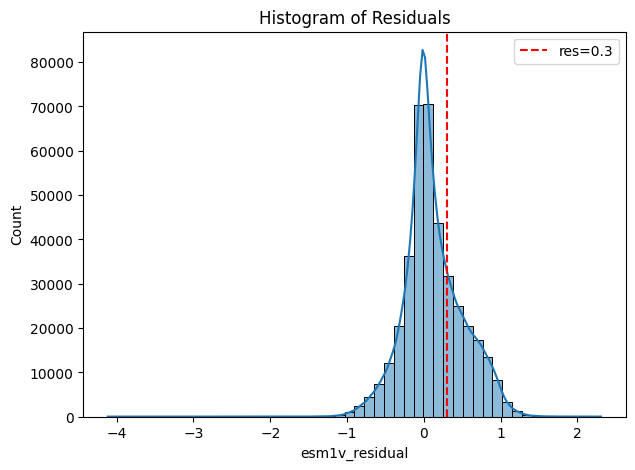

In [ ]:
# Plot distribution of residuals
plt.figure(figsize=(7,5))
sns.histplot(df_res["esm1v_residual"], bins=50, kde=True)
plt.axvline(0.3, color="red", linestyle="--", label="res=0.3")
plt.title("Histogram of Residuals")
plt.legend()
plt.show()

In [ ]:
#Output

df_res.to_csv("mutation_level_residuals_debug.csv", index=False)
print("Saved final residuals to mutation_level_residuals.csv")

Saved final residuals to mutation_level_residuals.csv


In [ ]:
#Residue-Level Aggregation & Save

if "uniprot_ID" not in df_res.columns:
  df_res["uniprot_ID"] = df_res["dom_ID"].str.split("_", n=1, expand=True)[0]

df_res['residue_key'] = df_res['uniprot_ID'] + '_' + df_res['pos_in_uniprot'].astype(str)

residue_agg = df_res.groupby('residue_key').agg(merged_residual=('esm1v_residual', 'mean'), n_mutations=('variant_ID', 'count'), dom_ID=('dom_ID', 'first'),
  pos_in_uniprot=('pos_in_uniprot', 'first'), uniprot_ID=('uniprot_ID', 'first')).reset_index()

#define 'likely_functional'
residue_agg['likely_functional'] = residue_agg['merged_residual'] > 0.3

residue_agg.to_csv("residue_level_functional_sites.csv", index=False)
print("Also saved residue-level file to residue_level_functional_sites.csv")

Also saved residue-level file to residue_level_functional_sites.csv


In [ ]:
# Number of likely functional sites (X)
X = residue_agg["likely_functional"].sum()

# Number of unique domains where these occur (Y)
Y = residue_agg.loc[residue_agg["likely_functional"], "dom_ID"].nunique()

print(f"Likely functional residues: {X}")
print(f"Across domains: {Y}")

Likely functional residues: 5079
Across domains: 389
